# Beginning

In [1]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import tree as tr
from sklearn.neural_network import MLPClassifier
from random_forestry import RandomForest
from cross_val import k_fold_cross_validation
from generalized_mlm_2 import MixtureLinearModel
from sklearn.metrics import f1_score

2024-11-02 16:58:10.845952: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 16:58:10.847713: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 16:58:10.883091: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 16:58:10.883597: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 16:58:11.987953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
path = './data/'
df = pd.read_csv(path + "TCGA_skcm.csv")

data = df.iloc[:,1:]
orig_headers = list(data)
outcome_header = "OS_STATUS"

feature_names = list(data)
feature_names.remove(outcome_header)

one_vars = np.where(np.array([len(np.unique(x)) for x in np.array(data).T])==1)[0]
for i in [orig_headers[i] for i in one_vars]:
    feature_names.remove(i)
    
Xo = data[feature_names].values
y = data[outcome_header].values


cate_vars = np.where((np.array([len(np.unique(x)) for x in np.array(Xo).T])<=12) &
                    (np.array([len(np.unique(x)) for x in np.array(Xo).T])>2))[0]
cont_vars = np.where((np.array([len(np.unique(x)) for x in np.array(Xo).T])>12) |
                    (np.array([len(np.unique(x)) for x in np.array(Xo).T])<=2))[0]
cate_vars = np.setdiff1d(cate_vars,[10])
cate_vars = np.sort(np.append(cate_vars,27))
cont_vars = np.setdiff1d(cont_vars,[27])
cont_vars = np.sort(np.append(cont_vars,10))

X_cate = Xo[:,cate_vars]
X_cont = Xo[:,cont_vars]
names_cont = [feature_names[i] for i in cont_vars]
names_cate = [feature_names[i] for i in cate_vars] 


X_cont_min, X_cont_max = X_cont.min(axis=0), X_cont.max(axis=0)
X_cont = (X_cont-X_cont_min)/(X_cont_max - X_cont_min + 1e-9)
    
df_cate = [pd.get_dummies(Xo[:,i], drop_first=True).values for i in cate_vars]
X_cate = np.hstack(df_cate)
a = sum([list(np.repeat(names_cate[i],j)) for i,j in enumerate([x.shape[1] for x in df_cate])],[])
b = sum([list(range(i)) for i in [x.shape[1] for x in df_cate]],[])
names_cate = ['{}{}'.format(a[i],b[i]) for i in range(len(b))]     
    
X = np.hstack([X_cont,X_cate])
feature_names = sum([names_cont,names_cate],[]) 


print(X.shape, y.shape, len(feature_names))
list(zip(feature_names,[len(np.unique(X[:,i])) for i in range(X.shape[1])]))

(388, 73) (388,) 73


[('AGE', 69),
 ('DAYS_TO_COLLECTION', 357),
 ('ETHNICITY', 2),
 ('FORM_COMPLETION_DATE', 104),
 ('FRACTION_GENOME_ALTERED', 372),
 ('HISTORY_NEOADJUVANT_TRTYN', 2),
 ('HISTORY_OTHER_MALIGNANCY', 2),
 ('ICD_10', 39),
 ('ICD_O_3_HISTOLOGY', 10),
 ('ICD_O_3_SITE', 35),
 ('INITIAL_PATHOLOGIC_DX_YEAR', 31),
 ('NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 2),
 ('OCT_EMBEDDED', 2),
 ('OS_MONTHS', 368),
 ('PRIMARY_MELANOMA_KNOWN_DX', 2),
 ('PROSPECTIVE_COLLECTION', 2),
 ('RADIATION_TREATMENT_ADJUVANT', 2),
 ('RETROSPECTIVE_COLLECTION', 2),
 ('SAMPLE_COUNT', 2),
 ('SAMPLE_INITIAL_WEIGHT', 76),
 ('SAMPLE_TYPE', 2),
 ('SAMPLE_TYPE_ID', 2),
 ('SEX', 2),
 ('SUBMITTED_TUMOR_DX_DAYS_TO', 260),
 ('VIAL_NUMBER', 2),
 ('AJCC_NODES_PATHOLOGIC_PN0', 2),
 ('AJCC_NODES_PATHOLOGIC_PN1', 2),
 ('AJCC_NODES_PATHOLOGIC_PN2', 2),
 ('AJCC_NODES_PATHOLOGIC_PN3', 2),
 ('AJCC_NODES_PATHOLOGIC_PN4', 2),
 ('AJCC_NODES_PATHOLOGIC_PN5', 2),
 ('AJCC_NODES_PATHOLOGIC_PN6', 2),
 ('AJCC_NODES_PATHOLOGIC_PN7', 2),
 ('AJCC_NODES_

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

In [6]:
clf_1 = RandomForestClassifier()
clf_1.fit(X_train, y_train)
print('auc train:', roc_auc_score(clf_1.predict(X_train), y_train))
print('auc test:', roc_auc_score(clf_1.predict(X_test), y_test))

auc train: 1.0
auc test: 0.7820855614973262


In [7]:
clf_2 = GradientBoostingClassifier()
clf_2.fit(X_train, y_train)
print('auc train:', roc_auc_score(clf_2.predict(X_train), y_train))
print('auc test:', roc_auc_score(clf_2.predict(X_test), y_test))

auc train: 0.9849397590361445
auc test: 0.7393048128342246


In [8]:
clf_3 = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(15, 2), random_state=1)
clf_3.fit(X_train, y_train)
print('auc train:', roc_auc_score(clf_3.predict(X_train), y_train))
print('auc test:', roc_auc_score(clf_3.predict(X_test), y_test))

auc train: 1.0
auc test: 0.6832564271588661


In [9]:
clf_4 = RandomForest(classification=True)
clf_4.fit(X_train, y_train)

forest_preds_train = clf_4.predict(X_train)
forest_preds = clf_4.predict(X_test)

print("Train", roc_auc_score(y_train, forest_preds_train))
print("Test", roc_auc_score(y_test, forest_preds))

x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


Train 0.9999999999999999
Test 0.8830213903743316


In [10]:
m1 = tr.DecisionTreeClassifier()
m1.fit(X_train, y_train)
m1_pred = m1.predict(X_train)
m1_pred_test = m1.predict(X_test)
print("Train DT:", roc_auc_score(m1_pred, y_train))
print("Test DT:", roc_auc_score(m1_pred_test, y_test), "depth", m1.get_depth())

m = LogisticRegression()
m.fit(X_train, y_train)
m_pred = m.predict(X_train)
m_pred_test = m.predict(X_test)
print("Train:", roc_auc_score(m_pred, y_train))
print("Test:", roc_auc_score(m_pred_test, y_test))

Train DT: 1.0
Test DT: 0.6778074866310159 depth 12
Train: 0.8119929006085194
Test: 0.7916666666666666


In [11]:
#Number of leaves in CART
m1.get_n_leaves()

49

In [12]:
fr = RandomForest(ntree=1)
fr.fit(X_train, y_train)

forest_preds_train = fr.predict(X_train)
forest_preds = fr.predict(X_test)

print("Train", roc_auc_score(y_train, forest_preds_train))
print("Test", roc_auc_score(y_test, forest_preds))

Train 0.8534745091500271
Test 0.6086229946524064


x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


# MLM Method

In [48]:
#Models to use for co-supervision
clfs = [clf_1, clf_2, clf_3]

sorted_clf = []
for i in clfs:
    sorted_clf.append((i, roc_auc_score(np.round(i.predict(X_test)), y_test)))
sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

In [14]:
avg_variance = np.mean(np.var(X_train, axis=0))

In [15]:
MLM = MixtureLinearModel(sorted_clf, verbose=True)

In [16]:
MLM.compute_kmeans_CELL(X_train, K=13, random_seed=0)

73 (73,)
# of CELL:13 / min size:13 / avg size:23.8 / max size:38 / # of singleton CELL:0


In [17]:
MLM.fit_LocalModels(X_train, y_train, 
                    eps=avg_variance, num_noise_samp=100, 
                    classification=True, alpha=0, max_iter=10000, random_seed=0)

Len of clf: 13


  0%|          | 0/13 [00:00<?, ?it/s]

cluster: 0 model: RandomForestClassifier()
cluster: 1 model: RandomForestClassifier()
cluster: 2 model: RandomForestClassifier()
cluster: 3 model: RandomForestClassifier()
cluster: 4 model: RandomForestClassifier()
cluster: 5 model: RandomForestClassifier()
cluster: 6 model: RandomForestClassifier()
cluster: 7 model: RandomForestClassifier()
cluster: 8 model: RandomForestClassifier()
cluster: 9 model: RandomForestClassifier()
cluster: 10 model: RandomForestClassifier()
cluster: 11 model: RandomForestClassifier()
cluster: 12 model: RandomForestClassifier()


  0%|          | 0/13 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.00608D-02

At iterate    1    f=  6.84631D-01    |proj g|=  6.73278D-02

At iterate    2    f=  5.59423D-01    |proj g|=  7.84841D-02

At iterate    3    f=  4.02378D-01    |proj g|=  3.33272D-02

At iterate    4    f=  3.53641D-01    |proj g|=  1.89251D-02

At iterate    5    f=  3.03778D-01    |proj g|=  1.24700D-02

At iterate    6    f=  2.43862D-01    |proj g|=  1.01105D-02

At iterate    7    f=  1.32046D-01    |proj g|=  4.99865D-03

At iterate    8    f=  7.61384D-02    |proj g|=  5.21406D-03

At iterate    9    f=  4.41893D-02    |proj g|=  4.56994D-03

At iterate   10    f=  2.65823D-02    |proj g|=  4.81941D-03

At iterate   11    f=  1.45710D-02    |proj g|=  3.88704D-03

At iterate   12    f=  9.67235D-03    |proj g|=  4.37316D-03

At iterate   13    f=  5.9

 This problem is unconstrained.
 This problem is unconstrained.
 15%|█▌        | 2/13 [00:00<00:00, 13.52it/s] This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.21077D-01

At iterate    1    f=  6.64824D-01    |proj g|=  5.60221D-02

At iterate    2    f=  5.73029D-01    |proj g|=  4.76564D-02

At iterate    3    f=  2.92346D-01    |proj g|=  2.62071D-02

At iterate    4    f=  2.20349D-01    |proj g|=  2.07035D-02

At iterate    5    f=  1.29512D-01    |proj g|=  9.76178D-03

At iterate    6    f=  7.88486D-02    |proj g|=  5.49208D-03

At iterate    7    f=  4.76117D-02    |proj g|=  2.13000D-03

At iterate    8    f=  2.86959D-02    |proj g|=  1.39036D-03

At iterate    9    f=  1.89362D-02    |proj g|=  3.93904D-03

At iterate   10    f=  1.01462D-02    |proj g|=  8.55142D-04

At iterate   11    f=  6.64335D-03    |proj g|=  9.05437D-04

At iterate   12    f=  6.21119D-03    |proj g|=  2.54157D-03

At iterate   13    f=  3.1

 This problem is unconstrained.
 This problem is unconstrained.
 46%|████▌     | 6/13 [00:00<00:00, 26.40it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.05106D-01

At iterate    1    f=  6.68434D-01    |proj g|=  4.47815D-02

At iterate    2    f=  5.61299D-01    |proj g|=  4.52184D-02

At iterate    3    f=  3.20217D-01    |proj g|=  2.09914D-02

At iterate    4    f=  2.51158D-01    |proj g|=  1.89368D-02

At iterate    5    f=  1.41109D-01    |proj g|=  1.48248D-02

At iterate    6    f=  1.03746D-01    |proj g|=  8.05256D-03

At iterate    7    f=  5.97625D-02    |proj g|=  2.99002D-03

At iterate    8    f=  3.42810D-02    |proj g|=  3.44080D-03

At iterate    9    f=  1.67180D-02    |proj g|=  1.06788D-03

At iterate   10    f=  8.49740D-03    |proj g|=  6.60013D-04

At iterate   11    f=  4.50048D-03    |proj g|=  4.32286D-04

At iterate   12    f=  2.59862D-03    |proj g|=  2.15010D-03

At iterate   13    f=  6.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 69%|██████▉   | 9/13 [00:00<00:00, 24.32it/s]


At iterate   10    f=  1.53444D-01    |proj g|=  4.98075D-03

At iterate   11    f=  1.35130D-01    |proj g|=  3.28514D-03

At iterate   12    f=  1.18257D-01    |proj g|=  1.08032D-02

At iterate   13    f=  1.12359D-01    |proj g|=  8.82908D-03

At iterate   14    f=  1.10278D-01    |proj g|=  5.50534D-03

At iterate   15    f=  1.05973D-01    |proj g|=  5.13147D-03

At iterate   16    f=  9.94792D-02    |proj g|=  4.77632D-03

At iterate   17    f=  8.80558D-02    |proj g|=  5.04172D-03

At iterate   18    f=  6.66342D-02    |proj g|=  6.99893D-03

At iterate   19    f=  5.32250D-02    |proj g|=  4.42185D-03

At iterate   20    f=  3.59144D-02    |proj g|=  1.80366D-03

At iterate   21    f=  2.21410D-02    |proj g|=  3.34214D-03

At iterate   22    f=  1.14881D-02    |proj g|=  9.73134D-04

At iterate   23    f=  6.77535D-03    |proj g|=  7.54690D-04

At iterate   24    f=  5.35876D-03    |proj g|=  3.56439D-03

At iterate   25    f=  2.63735D-03    |proj g|=  1.15509D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   23    f=  3.53115D-05    |proj g|=  9.91478D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   74     23     28      1     0     0   9.915D-06   3.531D-05
  F =   3.5311543600882171E-005

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.62668D-01

At iterate    1    f=  6.52114D-01    |proj g|=  4.70214D-02

At iterate    2    f=  5.54770D-01    |proj g|=  3.90807D-02

At iter

 This problem is unconstrained.
100%|██████████| 13/13 [00:00<00:00, 22.53it/s]


At iterate   36    f=  3.67409D-02    |proj g|=  2.09010D-03

At iterate   37    f=  3.46143D-02    |proj g|=  1.38952D-03

At iterate   38    f=  3.25883D-02    |proj g|=  1.43940D-03

At iterate   39    f=  2.71175D-02    |proj g|=  1.50664D-03

At iterate   40    f=  2.56331D-02    |proj g|=  3.34901D-03

At iterate   41    f=  2.12437D-02    |proj g|=  1.46875D-03

At iterate   42    f=  1.92918D-02    |proj g|=  1.05168D-03

At iterate   43    f=  1.65709D-02    |proj g|=  6.00560D-03

At iterate   44    f=  1.35368D-02    |proj g|=  4.30540D-03

At iterate   45    f=  7.89650D-03    |proj g|=  1.70172D-03

At iterate   46    f=  4.35698D-03    |proj g|=  7.37381D-04

At iterate   47    f=  2.10808D-03    |proj g|=  3.24131D-04

At iterate   48    f=  1.06138D-03    |proj g|=  1.58222D-04

At iterate   49    f=  5.40915D-04    |proj g|=  6.18652D-05

At iterate   50    f=  2.47201D-04    |proj g|=  5.59560D-05

At iterate   51    f=  1.21187D-04    |proj g|=  3.52290D-05

At iter

In [18]:
pred_lmm_train = MLM.predict(X_train, covariance_tied=False, uniform_prior=False)
pred_lmm_test = MLM.predict(X_test, covariance_tied=False, uniform_prior=False)

100%|██████████| 13/13 [00:00<00:00, 131.92it/s]


In [19]:
print('MLM-CELL: Train AUC:{:3.3f} / Test AUC:{:3.3f}'.format(
            roc_auc_score(y_train,np.array(pred_lmm_train)),
            roc_auc_score(y_test,np.array(pred_lmm_test))))

MLM-CELL: Train AUC:1.000 / Test AUC:0.755


In [20]:
MLM.fit_MergedLocalModels(10, classification=True, alpha=0, max_iter=10000, random_seed=0)

  0%|          | 0/10 [00:00<?, ?it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.79090D-01

At iterate    1    f=  5.31703D-01    |proj g|=  3.85192D-02

At iterate    2    f=  5.14852D-01    |proj g|=  2.64786D-02

At iterate    3    f=  4.38539D-01    |proj g|=  8.95389D-02

At iterate    4    f=  3.94493D-01    |proj g|=  7.97709D-02

At iterate    5    f=  2.96686D-01    |proj g|=  3.20772D-02

At iterate    6    f=  2.65767D-01    |proj g|=  1.76862D-02

At iterate    7    f=  2.45156D-01    |proj g|=  8.16797D-03

At iterate    8    f=  2.28365D-01    |proj g|=  9.77146D-03

At iterate    9    f=  2.06562D-01    |proj g|=  9.07650D-03

At iterate   10    f=  1.66535D-01    |proj g|=  7.15487D-03

At iterate   11    f=  1.56370D-01    |proj g|=  4.17052D-03

At iterate   12    f=  1.53354D-01    |proj g|=  2.19018D-02

At iterate   13    f=  1.4

 10%|█         | 1/10 [00:00<00:01,  5.40it/s] This problem is unconstrained.



At iterate   81    f=  1.84713D-02    |proj g|=  2.45457D-03

At iterate   82    f=  1.22848D-02    |proj g|=  2.48321D-03

At iterate   83    f=  1.01533D-02    |proj g|=  1.86370D-03

At iterate   84    f=  8.22847D-03    |proj g|=  1.64415D-03

At iterate   85    f=  6.70424D-03    |proj g|=  6.34435D-04

At iterate   86    f=  5.79866D-03    |proj g|=  7.48963D-04

At iterate   87    f=  4.50723D-03    |proj g|=  1.03761D-03

At iterate   88    f=  3.19222D-03    |proj g|=  6.08120D-04

At iterate   89    f=  2.47973D-03    |proj g|=  4.35444D-04

At iterate   90    f=  1.69691D-03    |proj g|=  3.10457D-04

At iterate   91    f=  9.75356D-04    |proj g|=  1.70251D-04

At iterate   92    f=  5.29595D-04    |proj g|=  8.34108D-05

At iterate   93    f=  2.81670D-04    |proj g|=  5.87353D-05

At iterate   94    f=  1.59552D-04    |proj g|=  3.31940D-05

At iterate   95    f=  8.23435D-05    |proj g|=  2.43352D-05

At iterate   96    f=  6.84726D-05    |proj g|=  2.55674D-05

At iter

 This problem is unconstrained.
 30%|███       | 3/10 [00:00<00:00,  8.23it/s] This problem is unconstrained.
 This problem is unconstrained.



At iterate   53    f=  4.69365D-05    |proj g|=  1.33797D-05

At iterate   54    f=  2.54585D-05    |proj g|=  1.26563D-05

At iterate   55    f=  1.29281D-05    |proj g|=  4.33755D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   74     55     63      1     0     0   4.338D-06   1.293D-05
  F =   1.2928135205050215E-005

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.05106D-01

At iter

 This problem is unconstrained.
 60%|██████    | 6/10 [00:00<00:00,  9.67it/s]


At iterate    9    f=  2.12344D-01    |proj g|=  8.24297D-03

At iterate   10    f=  1.84216D-01    |proj g|=  1.19137D-02

At iterate   11    f=  1.70053D-01    |proj g|=  7.75758D-03

At iterate   12    f=  1.68705D-01    |proj g|=  6.55222D-03

At iterate   13    f=  1.61200D-01    |proj g|=  5.71089D-03

At iterate   14    f=  1.57304D-01    |proj g|=  5.48644D-03

At iterate   15    f=  1.52720D-01    |proj g|=  3.98504D-03

At iterate   16    f=  1.45975D-01    |proj g|=  2.10354D-03

At iterate   17    f=  1.39223D-01    |proj g|=  2.66270D-03

At iterate   18    f=  1.30341D-01    |proj g|=  2.50728D-03

At iterate   19    f=  1.11121D-01    |proj g|=  3.23286D-03

At iterate   20    f=  9.46993D-02    |proj g|=  4.53877D-03

At iterate   21    f=  8.58400D-02    |proj g|=  3.05988D-03

At iterate   22    f=  8.08811D-02    |proj g|=  3.79363D-03

At iterate   23    f=  8.04514D-02    |proj g|=  2.53856D-03

At iterate   24    f=  7.85559D-02    |proj g|=  2.23109D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 80%|████████  | 8/10 [00:00<00:00,  8.43it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.64944D-02

At iterate    1    f=  6.54017D-01    |proj g|=  1.56428D-01

At iterate    2    f=  5.92126D-01    |proj g|=  5.82534D-02

At iterate    3    f=  5.82062D-01    |proj g|=  6.15785D-02

At iterate    4    f=  5.27456D-01    |proj g|=  8.58678D-02

At iterate    5    f=  4.55502D-01    |proj g|=  1.10623D-01

At iterate    6    f=  3.53837D-01    |proj g|=  8.56922D-02

At iterate    7    f=  2.91322D-01    |proj g|=  4.57859D-02

At iterate    8    f=  2.61136D-01    |proj g|=  1.67070D-02

At iterate    9    f=  2.48606D-01    |proj g|=  1.03066D-02

At iterate   10    f=  2.41550D-01    |proj g|=  1.83586D-02

At iterate   11    f=  2.33348D-01    |proj g|=  2.12899D-02

At iterate   12    f=  2.12412D-01    |proj g|=  1.51851D-02

At iterate   13    f=  1.8

 This problem is unconstrained.
100%|██████████| 10/10 [00:01<00:00,  8.74it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.36289D-01

At iterate    1    f=  6.60469D-01    |proj g|=  6.16436D-02

At iterate    2    f=  5.70857D-01    |proj g|=  5.19628D-02

At iterate    3    f=  3.11050D-01    |proj g|=  2.31797D-02

At iterate    4    f=  2.47133D-01    |proj g|=  1.57316D-02

At iterate    5    f=  1.80455D-01    |proj g|=  1.24168D-02

At iterate    6    f=  1.20288D-01    |proj g|=  1.05941D-02

At iterate    7    f=  9.37435D-02    |proj g|=  2.74037D-02

At iterate    8    f=  6.19917D-02    |proj g|=  1.74521D-02

At iterate    9    f=  4.79639D-02    |proj g|=  1.22042D-02

At iterate   10    f=  3.91017D-02    |proj g|=  8.55152D-03

At iterate   11    f=  2.90185D-02    |proj g|=  5.46092D-03

At iterate   12    f=  2.73093D-02    |proj g|=  1.35848D-02

At iterate   13    f=  1.6

In [21]:
pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)
pred_epic_test = MLM.predict(X_test, merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)

100%|██████████| 10/10 [00:00<00:00, 969.29it/s]


In [22]:
print('MLM-EPIC: Train AUC:{:3.3f} / Test AUC:{:3.3f}'.format(
            roc_auc_score(y_train,np.array(pred_epic_train)),
            roc_auc_score(y_test,np.array(pred_epic_test))))

MLM-EPIC: Train AUC:1.000 / Test AUC:0.813


## Random split runs 5 times for MLM-EPIC method

In [23]:
MLM_results_5_run_test = []
MLM_results_5_run_train = []
for run in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)    
    clf_1 = RandomForestClassifier()
    clf_1.fit(X_train, y_train)
    clf_2 = GradientBoostingClassifier()
    clf_2.fit(X_train, y_train)
    clf_3 = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(15, 2), random_state=0)
    clf_3.fit(X_train, y_train)
    clf_4 = RandomForest()
    clf_4.fit(X_train, y_train)
    
    #Pick the models you want to use for the MLM as a black-box models
    clfs = [clf_1, clf_2, clf_3, clf_4]
#     clfs = [clf_4]
    sorted_clf = []
    for i in clfs:
        sorted_clf.append((i, roc_auc_score(np.round(i.predict(X_test)), y_test)))
    sorted_clf = sorted(sorted_clf, key=lambda x: x[1])
    avg_variance = np.mean(np.var(X_train, axis=0))
    MLM = MixtureLinearModel(sorted_clf, verbose=True)
    MLM.compute_kmeans_CELL(X_train, K=13, random_seed=None)
    MLM.fit_LocalModels(X_train, y_train, 
                    eps=avg_variance, num_noise_samp=100, 
                    classification=True, alpha=0, max_iter=10000, random_seed=None)
    pred_lmm_train = MLM.predict(X_train, covariance_tied=False, uniform_prior=False)
    pred_lmm_test = MLM.predict(X_test, covariance_tied=False, uniform_prior=False)
    MLM.fit_MergedLocalModels(10, classification=True, alpha=0, max_iter=10000, random_seed=None)
    pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)
    pred_epic_test = MLM.predict(X_test, merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)
    
    MLM_results_5_run_train.append(roc_auc_score(y_train, np.array(pred_epic_train)))
    MLM_results_5_run_test.append(roc_auc_score(y_test, np.array(pred_epic_test)))

x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


73 (73,)
# of CELL:13 / min size:17 / avg size:23.8 / max size:38 / # of singleton CELL:0
cluster: (GradientBoostingClassifier(), 0.7479619565217391) model GradientBoostingClassifier()
Len of clf: 13


100%|██████████| 13/13 [00:00<00:00, 248.64it/s]


cluster: 0 model: MLPClassifier(alpha=1e-07, hidden_layer_sizes=(15, 2), random_state=0,
              solver='lbfgs')
cluster: 1 model: MLPClassifier(alpha=1e-07, hidden_layer_sizes=(15, 2), random_state=0,
              solver='lbfgs')
cluster: 2 model: GradientBoostingClassifier()
cluster: 3 model: MLPClassifier(alpha=1e-07, hidden_layer_sizes=(15, 2), random_state=0,
              solver='lbfgs')
cluster: 4 model: MLPClassifier(alpha=1e-07, hidden_layer_sizes=(15, 2), random_state=0,
              solver='lbfgs')
cluster: 5 model: GradientBoostingClassifier()
cluster: 6 model: GradientBoostingClassifier()
cluster: 7 model: GradientBoostingClassifier()
cluster: 8 model: GradientBoostingClassifier()
cluster: 9 model: RandomForest(ntree=500, replace=True, sampsize=310, sample_fraction=None, mtry=24, nodesize_spl=5, nodesize_avg=5, nodesize_strict_spl=1, nodesize_strict_avg=1, min_split_gain=0.0, max_depth=156, interaction_depth=156, splitratio=1.0, oob_honest=False, double_bootstrap=F

  8%|▊         | 1/13 [00:00<00:01,  7.27it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.19381D-02

At iterate    1    f=  6.82312D-01    |proj g|=  5.65288D-02

At iterate    2    f=  6.35218D-01    |proj g|=  6.16504D-02

At iterate    3    f=  3.54931D-01    |proj g|=  2.89362D-02

At iterate    4    f=  2.76298D-01    |proj g|=  2.06836D-02

At iterate    5    f=  1.70955D-01    |proj g|=  9.90414D-03

At iterate    6    f=  1.16469D-01    |proj g|=  4.26933D-03

At iterate    7    f=  8.43303D-02    |proj g|=  5.88976D-03

At iterate    8    f=  6.53094D-02    |proj g|=  3.18578D-03

At iterate    9    f=  5.79547D-02    |proj g|=  1.55205D-03

At iterate   10    f=  5.00673D-02    |proj g|=  1.11771D-03

At iterate   11    f=  4.38827D-02    |proj g|=  1.66145D-03

At iterate   12    f=  4.34953D-02    |proj g|=  1.46366D-03

At iterate   13    f=  3.8

 This problem is unconstrained.
 15%|█▌        | 2/13 [00:00<00:01,  5.82it/s]

At iterate    6    f=  1.11785D-01    |proj g|=  6.71708D-03

At iterate    7    f=  6.90588D-02    |proj g|=  9.16151D-03

At iterate    8    f=  4.95182D-02    |proj g|=  2.64651D-03

At iterate    9    f=  3.58671D-02    |proj g|=  4.90124D-03

At iterate   10    f=  2.55153D-02    |proj g|=  4.58305D-03

At iterate   11    f=  2.28810D-02    |proj g|=  5.76287D-03

At iterate   12    f=  1.82726D-02    |proj g|=  7.38190D-03

At iterate   13    f=  8.91025D-03    |proj g|=  2.60324D-03

At iterate   14    f=  5.15483D-03    |proj g|=  7.42673D-04

At iterate   15    f=  3.17390D-03    |proj g|=  3.92132D-04

At iterate   16    f=  1.78909D-03    |proj g|=  4.48781D-04

At iterate   17    f=  8.05785D-04    |proj g|=  8.81403D-05

At iterate   18    f=  4.89612D-04    |proj g|=  6.07225D-05

At iterate   19    f=  2.30745D-04    |proj g|=  3.51152D-05

At iterate   20    f=  1.11825D-04    |proj g|=  2.17832D-05

At iterate   21    f=  5.45067D-05    |proj g|=  6.33036D-06

        

 This problem is unconstrained.
 This problem is unconstrained.
 31%|███       | 4/13 [00:00<00:01,  8.83it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.41563D-02

At iterate    1    f=  5.76633D-01    |proj g|=  3.47370D-02

At iterate    2    f=  5.58524D-01    |proj g|=  1.37731D-01

At iterate    3    f=  3.53591D-01    |proj g|=  2.98115D-02

At iterate    4    f=  3.01142D-01    |proj g|=  1.54822D-02

At iterate    5    f=  2.33355D-01    |proj g|=  9.63851D-03

At iterate    6    f=  1.41032D-01    |proj g|=  6.11216D-03

At iterate    7    f=  8.65864D-02    |proj g|=  3.76442D-03

At iterate    8    f=  6.00492D-02    |proj g|=  4.21822D-03

At iterate    9    f=  4.70264D-02    |proj g|=  4.59500D-03

At iterate   10    f=  3.87372D-02    |proj g|=  3.62168D-03

At iterate   11    f=  3.06807D-02    |proj g|=  2.10581D-03

At iterate   12    f=  2.46672D-02    |proj g|=  9.14509D-04

At iterate   13    f=  2.3

 This problem is unconstrained.
 38%|███▊      | 5/13 [00:00<00:00,  8.29it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.70950D-01

At iterate    1    f=  6.46698D-01    |proj g|=  4.20577D-02

At iterate    2    f=  5.40919D-01    |proj g|=  3.21373D-02

At iterate    3    f=  2.66994D-01    |proj g|=  3.68427D-02

At iterate    4    f=  1.91909D-01    |proj g|=  2.46519D-02

At iterate    5    f=  1.26718D-01    |proj g|=  1.36258D-02

At iterate    6    f=  8.71806D-02    |proj g|=  6.47219D-03

At iterate    7    f=  5.92784D-02    |proj g|=  1.67635D-03

At iterate    8    f=  4.07026D-02    |proj g|=  1.78622D-03

At iterate    9    f=  2.68475D-02    |proj g|=  1.08856D-03

At iterate   10    f=  1.71179D-02    |proj g|=  1.85603D-03

At iterate   11    f=  1.00982D-02    |proj g|=  1.81378D-03

At iterate   12    f=  5.86566D-03    |proj g|=  2.77759D-03

At iterate   13    f=  3.4

 This problem is unconstrained.
 46%|████▌     | 6/13 [00:00<00:00,  8.34it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  5.22551D-02

At iterate    1    f=  6.83679D-01    |proj g|=  4.79669D-02

At iterate    2    f=  6.42896D-01    |proj g|=  4.97621D-02

At iterate    3    f=  4.10953D-01    |proj g|=  1.92974D-02

At iterate    4    f=  3.49210D-01    |proj g|=  1.52903D-02

At iterate    5    f=  2.45849D-01    |proj g|=  8.18434D-03

At iterate    6    f=  1.68491D-01    |proj g|=  1.63520D-02

At iterate    7    f=  1.07309D-01    |proj g|=  9.06285D-03

At iterate    8    f=  7.50469D-02    |proj g|=  3.41396D-03

At iterate    9    f=  4.38699D-02    |proj g|=  2.38955D-03

At iterate   10    f=  2.70875D-02    |proj g|=  3.34535D-03

At iterate   11    f=  1.18707D-02    |proj g|=  1.43262D-03

At iterate   12    f=  1.14300D-02    |proj g|=  2.69172D-03

At iterate   13    f=  9.0

 This problem is unconstrained.
 This problem is unconstrained.
 62%|██████▏   | 8/13 [00:00<00:00, 10.90it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  9.71848D-02

At iterate    1    f=  6.75923D-01    |proj g|=  5.16613D-02

At iterate    2    f=  6.11521D-01    |proj g|=  4.76562D-02

At iterate    3    f=  4.13123D-01    |proj g|=  1.97529D-02

At iterate    4    f=  3.52598D-01    |proj g|=  1.25354D-02

At iterate    5    f=  2.56676D-01    |proj g|=  7.35049D-03

At iterate    6    f=  2.02529D-01    |proj g|=  1.22834D-02

At iterate    7    f=  1.63473D-01    |proj g|=  5.54212D-03

At iterate    8    f=  1.26830D-01    |proj g|=  5.14291D-03

At iterate    9    f=  1.03351D-01    |proj g|=  7.21631D-03

At iterate   10    f=  8.21593D-02    |proj g|=  4.93897D-03

At iterate   11    f=  6.33922D-02    |proj g|=  2.39207D-03

At iterate   12    f=  6.10947D-02    |proj g|=  2.76031D-02

At iterate   13    f=  4.2

 This problem is unconstrained.
 This problem is unconstrained.
 77%|███████▋  | 10/13 [00:00<00:00, 12.99it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.36326D-01

At iterate    1    f=  6.62820D-01    |proj g|=  6.95366D-02

At iterate    2    f=  5.87612D-01    |proj g|=  5.93671D-02

At iterate    3    f=  3.18990D-01    |proj g|=  3.23401D-02

At iterate    4    f=  2.48274D-01    |proj g|=  2.16993D-02

At iterate    5    f=  1.83698D-01    |proj g|=  1.15186D-02

At iterate    6    f=  1.39014D-01    |proj g|=  7.48508D-03

At iterate    7    f=  9.00732D-02    |proj g|=  5.87042D-03

At iterate    8    f=  5.44630D-02    |proj g|=  3.02973D-03

At iterate    9    f=  3.50166D-02    |proj g|=  1.94128D-03

At iterate   10    f=  2.45839D-02    |proj g|=  1.58221D-03

At iterate   11    f=  1.41477D-02    |proj g|=  4.25616D-03

At iterate   12    f=  1.28714D-02    |proj g|=  4.60065D-03

At iterate   13    f=  7.8

 This problem is unconstrained.
 This problem is unconstrained.
 92%|█████████▏| 12/13 [00:01<00:00, 13.58it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.57776D-01

At iterate    1    f=  5.64829D-01    |proj g|=  4.89578D-02

At iterate    2    f=  5.42831D-01    |proj g|=  4.65147D-02

At iterate    3    f=  3.90923D-01    |proj g|=  1.40076D-01

At iterate    4    f=  3.18362D-01    |proj g|=  1.10957D-01

At iterate    5    f=  2.27822D-01    |proj g|=  5.26892D-02

At iterate    6    f=  1.85749D-01    |proj g|=  2.47862D-02

At iterate    7    f=  1.55908D-01    |proj g|=  1.27980D-02

At iterate    8    f=  1.30719D-01    |proj g|=  9.03158D-03

At iterate    9    f=  8.88715D-02    |proj g|=  8.56277D-03

At iterate   10    f=  5.32910D-02    |proj g|=  9.90881D-03

At iterate   11    f=  1.64022D-02    |proj g|=  3.01567D-03

At iterate   12    f=  9.98134D-03    |proj g|=  1.07135D-03

At iterate   13    f=  4.7

 This problem is unconstrained.
 20%|██        | 2/10 [00:00<00:01,  7.36it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  5.47604D-02

At iterate    1    f=  6.86698D-01    |proj g|=  5.12610D-02

At iterate    2    f=  6.54062D-01    |proj g|=  4.95760D-02

At iterate    3    f=  4.61868D-01    |proj g|=  4.17487D-02

At iterate    4    f=  4.50740D-01    |proj g|=  1.09797D-01

At iterate    5    f=  3.54852D-01    |proj g|=  3.33968D-02

At iterate    6    f=  3.35003D-01    |proj g|=  9.87101D-03

At iterate    7    f=  3.25342D-01    |proj g|=  1.24618D-02

At iterate    8    f=  3.11829D-01    |proj g|=  1.28688D-02

At iterate    9    f=  2.72815D-01    |proj g|=  1.60653D-02

At iterate   10    f=  2.57357D-01    |proj g|=  4.70356D-03

At iterate   11    f=  2.50908D-01    |proj g|=  2.41279D-03

At iterate   12    f=  2.48067D-01    |proj g|=  2.46808D-02

At iterate   13    f=  2.4

 This problem is unconstrained.
 30%|███       | 3/10 [00:00<00:00,  8.10it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.19381D-02

At iterate    1    f=  6.82312D-01    |proj g|=  5.65288D-02

At iterate    2    f=  6.35218D-01    |proj g|=  6.16504D-02

At iterate    3    f=  3.54931D-01    |proj g|=  2.89362D-02

At iterate    4    f=  2.76298D-01    |proj g|=  2.06836D-02

At iterate    5    f=  1.70955D-01    |proj g|=  9.90414D-03

At iterate    6    f=  1.16469D-01    |proj g|=  4.26933D-03

At iterate    7    f=  8.43303D-02    |proj g|=  5.88976D-03

At iterate    8    f=  6.53094D-02    |proj g|=  3.18578D-03

At iterate    9    f=  5.79547D-02    |proj g|=  1.55205D-03

At iterate   10    f=  5.00673D-02    |proj g|=  1.11771D-03

At iterate   11    f=  4.38827D-02    |proj g|=  1.66145D-03

At iterate   12    f=  4.34953D-02    |proj g|=  1.46366D-03

At iterate   13    f=  3.8

 This problem is unconstrained.
 50%|█████     | 5/10 [00:00<00:00,  8.71it/s] This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.41563D-02

At iterate    1    f=  5.76633D-01    |proj g|=  3.47370D-02

At iterate    2    f=  5.58524D-01    |proj g|=  1.37731D-01

At iterate    3    f=  3.53591D-01    |proj g|=  2.98115D-02

At iterate    4    f=  3.01142D-01    |proj g|=  1.54822D-02

At iterate    5    f=  2.33355D-01    |proj g|=  9.63851D-03

At iterate    6    f=  1.41032D-01    |proj g|=  6.11216D-03

At iterate    7    f=  8.65864D-02    |proj g|=  3.76442D-03

At iterate    8    f=  6.00492D-02    |proj g|=  4.21822D-03

At iterate    9    f=  4.70264D-02    |proj g|=  4.59500D-03

At iterate   10    f=  3.87372D-02    |proj g|=  3.62168D-03

At iterate   11    f=  3.06807D-02    |proj g|=  2.10581D-03

At iterate   12    f=  2.46672D-02    |proj g|=  9.14509D-04

At iterate   13    f=  2.3

 70%|███████   | 7/10 [00:00<00:00,  9.38it/s] This problem is unconstrained.
 This problem is unconstrained.
 90%|█████████ | 9/10 [00:00<00:00, 10.02it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   74     74     82      1     0     0   6.373D-06   3.586D-05
  F =   3.5862579390093218E-005

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.02952D-01

At iterate    1    f=  4.03704D-01    |proj g|=  8.96369D-02

At iterate    2    f=  3.63719D-01    |proj g|=  6.78391D-02

At iterate    3    f=  3.32067D-01    |proj g|=  3.07370D-02

At iter

 This problem is unconstrained.
100%|██████████| 10/10 [00:01<00:00,  9.06it/s]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  3.00333D-01

At iterate    1    f=  6.84626D-01    |proj g|=  1.67866D-01

At iterate    2    f=  5.31550D-01    |proj g|=  9.73704D-02

At iterate    3    f=  4.88484D-01    |proj g|=  3.00003D-02

At iterate    4    f=  4.65827D-01    |proj g|=  4.62142D-02

At iterate    5    f=  3.79002D-01    |proj g|=  9.84852D-02

At iterate    6    f=  2.95676D-01    |proj g|=  8.33183D-02

At iterate    7    f=  2.31798D-01    |proj g|=  4.65053D-02

At iterate    8    f=  1.87270D-01    |proj g|=  1.83657D-02

At iterate    9    f=  1.58859D-01    |proj g|=  7.38980D-03

At iterate   10    f=  1.32642D-01    |proj g|=  9.85031D-03

At iterate   11    f=  9.72815D-02    |proj g|=  6.62939D-03

At iterate   12    f=  4.74759D-02    |proj g|=  4.30306D-03

At iterate   13    f=  2.1

100%|██████████| 10/10 [00:00<00:00, 1094.98it/s]
x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


73 (73,)
# of CELL:13 / min size:10 / avg size:23.8 / max size:42 / # of singleton CELL:0
Len of clf: 13


100%|██████████| 13/13 [00:00<00:00, 206.86it/s]


cluster: 0 model: RandomForestClassifier()
cluster: 1 model: RandomForestClassifier()
cluster: 2 model: RandomForestClassifier()
cluster: 3 model: RandomForestClassifier()
cluster: 4 model: RandomForestClassifier()
cluster: 5 model: RandomForestClassifier()
cluster: 6 model: RandomForestClassifier()
cluster: 7 model: RandomForestClassifier()
cluster: 8 model: RandomForestClassifier()
cluster: 9 model: RandomForestClassifier()
cluster: 10 model: RandomForestClassifier()
cluster: 11 model: RandomForestClassifier()
cluster: 12 model: RandomForestClassifier()


  8%|▊         | 1/13 [00:00<00:01,  7.49it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.73032D-01

At iterate    1    f=  6.35724D-01    |proj g|=  4.84304D-02

At iterate    2    f=  5.74837D-01    |proj g|=  3.97430D-02

At iterate    3    f=  4.08182D-01    |proj g|=  7.04553D-02

At iterate    4    f=  3.56315D-01    |proj g|=  4.22895D-02

At iterate    5    f=  3.13946D-01    |proj g|=  1.34300D-02

At iterate    6    f=  2.95559D-01    |proj g|=  1.00548D-02

At iterate    7    f=  2.82522D-01    |proj g|=  1.71099D-02

At iterate    8    f=  2.65755D-01    |proj g|=  2.11944D-02

At iterate    9    f=  2.29310D-01    |proj g|=  1.78800D-02

At iterate   10    f=  1.93259D-01    |proj g|=  7.58688D-03

At iterate   11    f=  1.77602D-01    |proj g|=  4.76923D-03

At iterate   12    f=  1.61358D-01    |proj g|=  1.17430D-02

At iterate   13    f=  1.5

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  7.05695D-02

At iterate    1    f=  6.81294D-01    |proj g|=  3.82574D-02

At iterate    2    f=  5.98569D-01    |proj g|=  5.03719D-02

At iterate    3    f=  4.26060D-01    |proj g|=  2.37720D-02

At iterate    4    f=  3.67221D-01    |proj g|=  1.44489D-02

At iterate    5    f=  2.94567D-01    |proj g|=  1.00033D-02

At iterate    6    f=  2.22167D-01    |proj g|=  1.24455D-02

At iterate    7    f=  1.87027D-01    |proj g|=  1.39423D-02

At iterate    8    f=  1.50771D-01    |proj g|=  5.67156D-03

At iterate    9    f=  1.29811D-01    |proj g|=  4.63741D-03

At iterate   10    f=  9.10360D-02    |proj g|=  6.15292D-03

At iterate   11    f=  6.24764D-02    |proj g|=  2.67174D-03

At iterate   12    f=  5.75585D-02    |proj g|=  1.43789D-02

At iterate   13    f=  4.4

 This problem is unconstrained.
 23%|██▎       | 3/13 [00:00<00:01,  9.75it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.94757D-01

At iterate    1    f=  5.13378D-01    |proj g|=  4.95879D-02

At iterate    2    f=  4.93691D-01    |proj g|=  4.42366D-02

At iterate    3    f=  3.85459D-01    |proj g|=  1.28902D-01

At iterate    4    f=  3.23819D-01    |proj g|=  1.03249D-01

At iterate    5    f=  2.34775D-01    |proj g|=  4.53326D-02

At iterate    6    f=  2.04277D-01    |proj g|=  2.28803D-02

At iterate    7    f=  1.87252D-01    |proj g|=  1.02320D-02

At iterate    8    f=  1.75772D-01    |proj g|=  1.14477D-02

At iterate    9    f=  1.58970D-01    |proj g|=  1.42019D-02

At iterate   10    f=  1.24524D-01    |proj g|=  1.25021D-02

At iterate   11    f=  6.91973D-02    |proj g|=  4.02381D-03

At iterate   12    f=  5.95437D-02    |proj g|=  2.86215D-03

At iterate   13    f=  4.5

 31%|███       | 4/13 [00:00<00:00,  9.70it/s] This problem is unconstrained.
 This problem is unconstrained.



At iterate    8    f=  4.08744D-02    |proj g|=  3.67466D-03

At iterate    9    f=  2.91021D-02    |proj g|=  2.31046D-03

At iterate   10    f=  2.01540D-02    |proj g|=  2.45445D-03

At iterate   11    f=  1.28526D-02    |proj g|=  2.12195D-03

At iterate   12    f=  1.27493D-02    |proj g|=  1.80069D-03

At iterate   13    f=  7.67604D-03    |proj g|=  1.11496D-03

At iterate   14    f=  4.32273D-03    |proj g|=  7.08554D-04

At iterate   15    f=  1.98668D-03    |proj g|=  2.67333D-04

At iterate   16    f=  1.00512D-03    |proj g|=  1.14858D-04

At iterate   17    f=  5.08275D-04    |proj g|=  9.59039D-05

At iterate   18    f=  2.56510D-04    |proj g|=  2.93552D-05

At iterate   19    f=  1.34098D-04    |proj g|=  1.60940D-05

At iterate   20    f=  6.68172D-05    |proj g|=  7.82060D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 54%|█████▍    | 7/13 [00:00<00:00, 16.22it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.27078D-01

At iterate    1    f=  5.92497D-01    |proj g|=  5.81199D-02

At iterate    2    f=  5.75265D-01    |proj g|=  4.90695D-02

At iterate    3    f=  4.77445D-01    |proj g|=  1.16820D-01

At iterate    4    f=  4.04354D-01    |proj g|=  1.11321D-01

At iterate    5    f=  2.84347D-01    |proj g|=  5.00173D-02

At iterate    6    f=  2.24965D-01    |proj g|=  1.79805D-02

At iterate    7    f=  1.91923D-01    |proj g|=  6.16176D-03

At iterate    8    f=  1.71818D-01    |proj g|=  1.20256D-02

At iterate    9    f=  1.51081D-01    |proj g|=  1.47674D-02

At iterate   10    f=  1.05929D-01    |proj g|=  1.54649D-02

At iterate   11    f=  5.29444D-02    |proj g|=  8.02433D-03

At iterate   12    f=  4.71748D-02    |proj g|=  3.08444D-03

At iterate   13    f=  3.7

 77%|███████▋  | 10/13 [00:00<00:00, 20.33it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
100%|██████████| 13/13 [00:00<00:00, 18.75it/s]


At iterate   29    f=  3.78299D-02    |proj g|=  7.40459D-03

At iterate   30    f=  3.24706D-02    |proj g|=  2.41668D-03

At iterate   31    f=  2.92188D-02    |proj g|=  3.99145D-03

At iterate   32    f=  2.62362D-02    |proj g|=  1.72538D-03

At iterate   33    f=  2.20857D-02    |proj g|=  1.33445D-03

At iterate   34    f=  1.54981D-02    |proj g|=  1.22286D-03

At iterate   35    f=  1.38664D-02    |proj g|=  5.24275D-03

At iterate   36    f=  8.98843D-03    |proj g|=  2.95180D-03

At iterate   37    f=  5.69646D-03    |proj g|=  1.29716D-03

At iterate   38    f=  3.23800D-03    |proj g|=  4.71019D-04

At iterate   39    f=  1.65667D-03    |proj g|=  2.33836D-04

At iterate   40    f=  8.24060D-04    |proj g|=  1.43159D-04

At iterate   41    f=  4.09450D-04    |proj g|=  8.45506D-05

At iterate   42    f=  2.03335D-04    |proj g|=  4.29150D-05

At iterate   43    f=  1.01007D-04    |proj g|=  2.43360D-05

At iterate   44    f=  5.03479D-05    |proj g|=  1.33535D-05

At iter


 10%|█         | 1/10 [00:00<00:01,  5.74it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.07111D-01

At iterate    1    f=  6.70741D-01    |proj g|=  6.03521D-02

At iterate    2    f=  6.05435D-01    |proj g|=  4.98909D-02

At iterate    3    f=  4.03786D-01    |proj g|=  1.54309D-02

At iterate    4    f=  3.40275D-01    |proj g|=  1.07375D-02

At iterate    5    f=  2.55035D-01    |proj g|=  7.41359D-03

At iterate    6    f=  1.93853D-01    |proj g|=  9.34672D-03

At iterate    7    f=  1.45670D-01    |proj g|=  2.71414D-03

At iterate    8    f=  1.29374D-01    |proj g|=  2.46730D-03

At iterate    9    f=  1.17432D-01    |proj g|=  2.35799D-03

At iterate   10    f=  1.11618D-01    |proj g|=  1.26136D-03

At iterate   11    f=  1.08358D-01    |proj g|=  1.11157D-03

At iterate   12    f=  1.07121D-01    |proj g|=  1.66571D-02

At iterate   13    f=  1.0

 This problem is unconstrained.
 This problem is unconstrained.
 30%|███       | 3/10 [00:00<00:00,  8.10it/s] This problem is unconstrained.
 This problem is unconstrained.
 50%|█████     | 5/10 [00:00<00:00, 10.92it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.73032D-01

At iterate    1    f=  6.35724D-01    |proj g|=  4.84304D-02

At iterate    2    f=  5.74837D-01    |proj g|=  3.97430D-02

At iterate    3    f=  4.08182D-01    |proj g|=  7.04553D-02

At iterate    4    f=  3.56315D-01    |proj g|=  4.22895D-02

At iterate    5    f=  3.13946D-01    |proj g|=  1.34300D-02

At iterate    6    f=  2.95559D-01    |proj g|=  1.00548D-02

At iterate    7    f=  2.82522D-01    |proj g|=  1.71099D-02

At iterate    8    f=  2.65755D-01    |proj g|=  2.11944D-02

At iterate    9    f=  2.29310D-01    |proj g|=  1.78800D-02

At iterate   10    f=  1.93259D-01    |proj g|=  7.58688D-03

At iterate   11    f=  1.77602D-01    |proj g|=  4.76923D-03

At iterate   12    f=  1.61358D-01    |proj g|=  1.17430D-02

At iterate   13    f=  1.5

 This problem is unconstrained.
 This problem is unconstrained.
 80%|████████  | 8/10 [00:00<00:00, 16.31it/s] This problem is unconstrained.
 This problem is unconstrained.
100%|██████████| 10/10 [00:00<00:00, 14.86it/s]



At iterate   28    f=  2.11769D-04    |proj g|=  4.55423D-05

At iterate   29    f=  1.07176D-04    |proj g|=  2.51214D-05

At iterate   30    f=  5.87923D-05    |proj g|=  1.55577D-05

At iterate   31    f=  2.02429D-05    |proj g|=  9.78161D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   74     31     35      1     0     0   9.782D-06   2.024D-05
  F =   2.0242865328367663E-005

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iter

100%|██████████| 10/10 [00:00<00:00, 838.73it/s]
x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


73 (73,)
# of CELL:13 / min size:9 / avg size:23.8 / max size:43 / # of singleton CELL:0
Len of clf: 13


 23%|██▎       | 3/13 [00:00<00:00, 28.65it/s]

cluster: 0 model: RandomForest(ntree=500, replace=True, sampsize=310, sample_fraction=None, mtry=24, nodesize_spl=5, nodesize_avg=5, nodesize_strict_spl=1, nodesize_strict_avg=1, min_split_gain=0.0, max_depth=156, interaction_depth=156, splitratio=1.0, oob_honest=False, double_bootstrap=False, seed=780, verbose=False, nthread=0, splitrule='variance', middle_split=False, max_obs=310, linear=False, min_trees_per_fold=0, fold_size=1, monotone_avg=False, overfit_penalty=1, scale=False, double_tree=False, na_direction=False, forest=<capsule object NULL at 0x14c3f99634b0>, dataframe=<capsule object NULL at 0x14c3f9963ae0>, processed_dta=ProcessedDta(processed_x=           0         1    2         3         4    5    6         7   \
0    0.946667  0.009687  1.0  0.145631  0.478734  0.0  0.0  0.342105   
1    0.653333  0.290188  1.0  0.067961  0.268074  1.0  0.0  1.000000   
2    0.853333  0.138288  1.0  0.466019  0.000106  0.0  0.0  0.631579   
3    0.880000  0.013445  0.0  0.524272  0.437467

 69%|██████▉   | 9/13 [00:00<00:00, 27.78it/s]

cluster: 6 model: RandomForest(ntree=500, replace=True, sampsize=310, sample_fraction=None, mtry=24, nodesize_spl=5, nodesize_avg=5, nodesize_strict_spl=1, nodesize_strict_avg=1, min_split_gain=0.0, max_depth=156, interaction_depth=156, splitratio=1.0, oob_honest=False, double_bootstrap=False, seed=780, verbose=False, nthread=0, splitrule='variance', middle_split=False, max_obs=310, linear=False, min_trees_per_fold=0, fold_size=1, monotone_avg=False, overfit_penalty=1, scale=False, double_tree=False, na_direction=False, forest=<capsule object NULL at 0x14c3f99634b0>, dataframe=<capsule object NULL at 0x14c3f9963ae0>, processed_dta=ProcessedDta(processed_x=           0         1    2         3         4    5    6         7   \
0    0.946667  0.009687  1.0  0.145631  0.478734  0.0  0.0  0.342105   
1    0.653333  0.290188  1.0  0.067961  0.268074  1.0  0.0  1.000000   
2    0.853333  0.138288  1.0  0.466019  0.000106  0.0  0.0  0.631579   
3    0.880000  0.013445  0.0  0.524272  0.437467

100%|██████████| 13/13 [00:00<00:00, 26.28it/s]


cluster: 12 model: RandomForest(ntree=500, replace=True, sampsize=310, sample_fraction=None, mtry=24, nodesize_spl=5, nodesize_avg=5, nodesize_strict_spl=1, nodesize_strict_avg=1, min_split_gain=0.0, max_depth=156, interaction_depth=156, splitratio=1.0, oob_honest=False, double_bootstrap=False, seed=780, verbose=False, nthread=0, splitrule='variance', middle_split=False, max_obs=310, linear=False, min_trees_per_fold=0, fold_size=1, monotone_avg=False, overfit_penalty=1, scale=False, double_tree=False, na_direction=False, forest=<capsule object NULL at 0x14c3f99634b0>, dataframe=<capsule object NULL at 0x14c3f9963ae0>, processed_dta=ProcessedDta(processed_x=           0         1    2         3         4    5    6         7   \
0    0.946667  0.009687  1.0  0.145631  0.478734  0.0  0.0  0.342105   
1    0.653333  0.290188  1.0  0.067961  0.268074  1.0  0.0  1.000000   
2    0.853333  0.138288  1.0  0.466019  0.000106  0.0  0.0  0.631579   
3    0.880000  0.013445  0.0  0.524272  0.43746

  0%|          | 0/13 [00:00<?, ?it/s] This problem is unconstrained.
 This problem is unconstrained.
 15%|█▌        | 2/13 [00:00<00:00, 19.31it/s] This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.80367D-01

At iterate    1    f=  5.56647D-01    |proj g|=  4.68262D-02

At iterate    2    f=  5.34488D-01    |proj g|=  3.91573D-02

At iterate    3    f=  3.90404D-01    |proj g|=  1.47865D-01

At iterate    4    f=  3.17104D-01    |proj g|=  1.18901D-01

At iterate    5    f=  2.21835D-01    |proj g|=  5.98095D-02

At iterate    6    f=  1.76550D-01    |proj g|=  3.17547D-02

At iterate    7    f=  1.43786D-01    |proj g|=  1.52904D-02

At iterate    8    f=  1.17550D-01    |proj g|=  8.06311D-03

At iterate    9    f=  8.40012D-02    |proj g|=  6.75867D-03

At iterate   10    f=  3.51120D-02    |proj g|=  3.17020D-03

At iterate   11    f=  1.52911D-02    |proj g|=  1.79620D-03

At iterate   12    f=  7.48202D-03    |proj g|=  2.13688D-03

At iterate   13    f=  3.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 62%|██████▏   | 8/13 [00:00<00:00, 37.48it/s]


At iterate   10    f=  8.36877D-02    |proj g|=  9.26523D-03

At iterate   11    f=  6.98821D-02    |proj g|=  5.95294D-03

At iterate   12    f=  4.42806D-02    |proj g|=  5.69118D-03

At iterate   13    f=  4.19710D-02    |proj g|=  5.98082D-03

At iterate   14    f=  2.95824D-02    |proj g|=  4.90931D-03

At iterate   15    f=  1.35564D-02    |proj g|=  1.27936D-03

At iterate   16    f=  8.19070D-03    |proj g|=  1.75000D-03

At iterate   17    f=  3.63498D-03    |proj g|=  3.93989D-04

At iterate   18    f=  2.13684D-03    |proj g|=  2.04698D-04

At iterate   19    f=  1.00132D-03    |proj g|=  8.58420D-05

At iterate   20    f=  5.10332D-04    |proj g|=  4.24237D-05

At iterate   21    f=  2.60790D-04    |proj g|=  4.83367D-05

At iterate   22    f=  1.25255D-04    |proj g|=  1.19932D-05

At iterate   23    f=  6.56178D-05    |proj g|=  6.23989D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 92%|█████████▏| 12/13 [00:00<00:00, 38.14it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.18925D-01

At iterate    1    f=  5.93196D-01    |proj g|=  5.92405D-02

At iterate    2    f=  5.08657D-01    |proj g|=  8.14492D-02

At iterate    3    f=  3.71978D-01    |proj g|=  1.03958D-01

At iterate    4    f=  2.73855D-01    |proj g|=  6.37752D-02

At iterate    5    f=  2.07400D-01    |proj g|=  3.13278D-02

At iterate    6    f=  1.65323D-01    |proj g|=  1.33156D-02

At iterate    7    f=  1.30815D-01    |proj g|=  1.02832D-02

At iterate    8    f=  9.41580D-02    |proj g|=  1.14319D-02

At iterate    9    f=  4.35564D-02    |proj g|=  2.78602D-03

At iterate   10    f=  2.20114D-02    |proj g|=  1.99109D-03

At iterate   11    f=  1.00860D-02    |proj g|=  1.12774D-03

At iterate   12    f=  8.78978D-03    |proj g|=  4.01909D-03

At iterate   13    f=  4.1

 This problem is unconstrained.
100%|██████████| 13/13 [00:00<00:00, 37.59it/s]



At iterate    0    f=  6.93147D-01    |proj g|=  7.75711D-02

At iterate    1    f=  6.38509D-01    |proj g|=  1.93511D-01

At iterate    2    f=  5.33734D-01    |proj g|=  1.32490D-01

At iterate    3    f=  2.91037D-01    |proj g|=  2.86203D-02

At iterate    4    f=  2.39530D-01    |proj g|=  2.19613D-02

At iterate    5    f=  1.27216D-01    |proj g|=  1.00056D-02

At iterate    6    f=  7.28152D-02    |proj g|=  5.79445D-03

At iterate    7    f=  3.68843D-02    |proj g|=  5.18626D-03

At iterate    8    f=  2.17408D-02    |proj g|=  1.97779D-03

At iterate    9    f=  1.07628D-02    |proj g|=  9.46386D-04

At iterate   10    f=  5.49392D-03    |proj g|=  6.01276D-04

At iterate   11    f=  2.80185D-03    |proj g|=  6.22649D-04

At iterate   12    f=  1.51656D-03    |proj g|=  6.06716D-04

At iterate   13    f=  7.96230D-04    |proj g|=  2.11789D-04

At iterate   14    f=  4.16639D-04    |proj g|=  1.04044D-04

At iterate   15    f=  2.10787D-04    |proj g|=  4.17912D-05

At iter

 10%|█         | 1/10 [00:00<00:01,  7.01it/s] This problem is unconstrained.
 This problem is unconstrained.
 30%|███       | 3/10 [00:00<00:00, 13.46it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42065D-01

At iterate    1    f=  6.53551D-01    |proj g|=  6.20953D-02

At iterate    2    f=  6.20666D-01    |proj g|=  6.06653D-02

At iterate    3    f=  4.48509D-01    |proj g|=  4.60413D-02

At iterate    4    f=  3.30904D-01    |proj g|=  2.93961D-02

At iterate    5    f=  2.21513D-01    |proj g|=  1.38273D-02

At iterate    6    f=  1.62310D-01    |proj g|=  1.00494D-02

At iterate    7    f=  1.17254D-01    |proj g|=  8.21930D-03

At iterate    8    f=  8.50564D-02    |proj g|=  8.70167D-03

At iterate    9    f=  6.03180D-02    |proj g|=  2.68847D-03

At iterate   10    f=  4.66869D-02    |proj g|=  1.46195D-03

At iterate   11    f=  3.39557D-02    |proj g|=  2.09722D-03

At iterate   12    f=  3.36012D-02    |proj g|=  1.98065D-03

At iterate   13    f=  2.3

 This problem is unconstrained.
 This problem is unconstrained.
 60%|██████    | 6/10 [00:00<00:00, 14.86it/s] This problem is unconstrained.



At iterate   28    f=  1.58325D-03    |proj g|=  1.37793D-04

At iterate   29    f=  8.91086D-04    |proj g|=  1.55892D-04

At iterate   30    f=  4.20091D-04    |proj g|=  6.08933D-05

At iterate   31    f=  2.12841D-04    |proj g|=  3.24746D-05

At iterate   32    f=  1.05237D-04    |proj g|=  1.41037D-05

At iterate   33    f=  5.26635D-05    |proj g|=  7.61996D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   74     33     39      1     0     0   7.620D-06   5.266D-05
  F =   5.2663459892252109E-005

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 80%|████████  | 8/10 [00:00<00:00, 14.88it/s] This problem is unconstrained.
 This problem is unconstrained.
100%|██████████| 10/10 [00:00<00:00, 16.22it/s]



At iterate   46    f=  3.82175D-02    |proj g|=  3.06767D-03

At iterate   47    f=  3.70348D-02    |proj g|=  1.19945D-03

At iterate   48    f=  3.64144D-02    |proj g|=  6.95337D-04

At iterate   49    f=  3.58143D-02    |proj g|=  1.42252D-03

At iterate   50    f=  3.53094D-02    |proj g|=  1.47135D-03

At iterate   51    f=  3.50500D-02    |proj g|=  1.36204D-03

At iterate   52    f=  3.41572D-02    |proj g|=  1.23443D-03

At iterate   53    f=  3.35212D-02    |proj g|=  2.00365D-03

At iterate   54    f=  3.26985D-02    |proj g|=  1.29360D-03

At iterate   55    f=  3.19842D-02    |proj g|=  4.91676D-04

At iterate   56    f=  3.16213D-02    |proj g|=  9.32280D-04

At iterate   57    f=  3.09921D-02    |proj g|=  1.06993D-03

At iterate   58    f=  2.94269D-02    |proj g|=  1.32549D-03

At iterate   59    f=  2.88027D-02    |proj g|=  1.65776D-03

At iterate   60    f=  2.69378D-02    |proj g|=  4.69046D-04

At iterate   61    f=  2.59612D-02    |proj g|=  6.33920D-04

At iter

100%|██████████| 10/10 [00:00<00:00, 309.71it/s]
x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


73 (73,)
# of CELL:13 / min size:7 / avg size:23.8 / max size:48 / # of singleton CELL:0
Len of clf: 13


100%|██████████| 13/13 [00:00<00:00, 212.15it/s]


cluster: 0 model: GradientBoostingClassifier()
cluster: 1 model: GradientBoostingClassifier()
cluster: 2 model: GradientBoostingClassifier()
cluster: 3 model: MLPClassifier(alpha=1e-07, hidden_layer_sizes=(15, 2), random_state=0,
              solver='lbfgs')
cluster: 4 model: GradientBoostingClassifier()
cluster: 5 model: RandomForest(ntree=500, replace=True, sampsize=310, sample_fraction=None, mtry=24, nodesize_spl=5, nodesize_avg=5, nodesize_strict_spl=1, nodesize_strict_avg=1, min_split_gain=0.0, max_depth=156, interaction_depth=156, splitratio=1.0, oob_honest=False, double_bootstrap=False, seed=780, verbose=False, nthread=0, splitrule='variance', middle_split=False, max_obs=310, linear=False, min_trees_per_fold=0, fold_size=1, monotone_avg=False, overfit_penalty=1, scale=False, double_tree=False, na_direction=False, forest=<capsule object NULL at 0x14c3f9963750>, dataframe=<capsule object NULL at 0x14c3f9962880>, processed_dta=ProcessedDta(processed_x=           0         1    2  

  0%|          | 0/13 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.11710D-01

At iterate    1    f=  6.00150D-01    |proj g|=  5.60981D-02

At iterate    2    f=  5.07302D-01    |proj g|=  6.06948D-02

At iterate    3    f=  3.49036D-01    |proj g|=  9.62286D-02

At iterate    4    f=  2.62688D-01    |proj g|=  6.12119D-02

At iterate    5    f=  1.99869D-01    |proj g|=  3.17888D-02

At iterate    6    f=  1.64641D-01    |proj g|=  1.59695D-02

At iterate    7    f=  1.37364D-01    |proj g|=  8.24118D-03

At iterate    8    f=  1.07803D-01    |proj g|=  7.66574D-03

At iterate    9    f=  6.88167D-02    |proj g|=  7.44246D-03

At iterate   10    f=  3.82531D-02    |proj g|=  5.92336D-03

At iterate   11    f=  2.00402D-02    |proj g|=  8.25033D-04

At iterate   12    f=  1.52912D-02    |proj g|=  1.48609D-03

At iterate   13    f=  1.4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  5.52192D-02

At iterate    1    f=  6.83243D-01    |proj g|=  6.44179D-02

At iterate    2    f=  6.15022D-01    |proj g|=  6.58171D-02


 15%|█▌        | 2/13 [00:00<00:01,  7.45it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    3    f=  3.62750D-01    |proj g|=  1.76426D-02

At iterate    4    f=  2.95328D-01    |proj g|=  1.31650D-02

At iterate    5    f=  2.06698D-01    |proj g|=  9.17686D-03

At iterate    6    f=  1.30896D-01    |proj g|=  1.55566D-02

At iterate    7    f=  7.11120D-02    |proj g|=  2.76903D-03

At iterate    8    f=  5.15268D-02    |proj g|=  2.97059D-03

At iterate    9    f=  3.29633D-02    |proj g|=  2.25118D-03

At iterate   10    f=  1.99434D-02    |proj g|=  2.15299D-03

At iterate   11    f=  1.04718D-02    |proj g|=  1.10328D-03

At iterate   12    f=  1.02211D-02    |proj g|=  1.32574D-03

At iterate   13    f=  7.05521D-03    |proj g|=  1.15923D-03

At iterate   14    f=  3.44124D-03    |proj g|=  4.49605D-04

At iterate   15    f=  1.84901D-03    |proj g|=  2.80263D-04

At iterate   16    f=  9.12723D-04    |proj g|=  8.39215D-05

At iterate   17    f=  4.56242D-04    |proj g|=  7.18116D-05

At iterate   18    f=  2.45447D-04    |proj g|=  6.95371D-05

At iter

 46%|████▌     | 6/13 [00:00<00:00, 15.78it/s]


At iterate    3    f=  3.89164D-01    |proj g|=  3.38999D-02

At iterate    4    f=  3.35673D-01    |proj g|=  1.77634D-02

At iterate    5    f=  2.95604D-01    |proj g|=  8.08588D-03

At iterate    6    f=  2.67386D-01    |proj g|=  1.14742D-02

At iterate    7    f=  2.27032D-01    |proj g|=  8.49517D-03

At iterate    8    f=  1.75104D-01    |proj g|=  1.35251D-02

At iterate    9    f=  1.34362D-01    |proj g|=  3.40702D-03

At iterate   10    f=  1.11545D-01    |proj g|=  3.19901D-03

At iterate   11    f=  7.87333D-02    |proj g|=  7.05156D-03

At iterate   12    f=  7.73172D-02    |proj g|=  6.94871D-03

At iterate   13    f=  7.02496D-02    |proj g|=  4.17548D-03

At iterate   14    f=  6.35844D-02    |proj g|=  2.05264D-03

At iterate   15    f=  5.93081D-02    |proj g|=  1.02667D-03

At iterate   16    f=  5.56095D-02    |proj g|=  1.03456D-03

At iterate   17    f=  5.06685D-02    |proj g|=  1.15954D-03

At iterate   18    f=  4.12598D-02    |proj g|=  2.20013D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 85%|████████▍ | 11/13 [00:00<00:00, 24.83it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.61696D-01

At iterate    1    f=  6.47322D-01    |proj g|=  3.64819D-02

At iterate    2    f=  5.71137D-01    |proj g|=  4.68476D-02

At iterate    3    f=  3.45360D-01    |proj g|=  5.46981D-02

At iterate    4    f=  2.67137D-01    |proj g|=  3.81754D-02

At iterate    5    f=  1.77008D-01    |proj g|=  1.78311D-02

At iterate    6    f=  1.30065D-01    |proj g|=  7.22027D-03

At iterate    7    f=  9.43647D-02    |proj g|=  4.56413D-03

At iterate    8    f=  6.37496D-02    |proj g|=  4.21003D-03

At iterate    9    f=  3.57499D-02    |proj g|=  2.79360D-03

At iterate   10    f=  1.80209D-02    |proj g|=  1.79916D-03

At iterate   11    f=  1.02047D-02    |proj g|=  1.07903D-03

At iterate   12    f=  8.88458D-03    |proj g|=  4.12589D-03

At iterate   13    f=  5.1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   13    f=  5.16447D-03    |proj g|=  9.84517D-04

At iterate   14    f=  3.57889D-03    |proj g|=  5.71550D-04

At iterate   15    f=  2.28826D-03    |proj g|=  3.07998D-04

At iterate   16    f=  1.38914D-03    |proj g|=  1.76060D-04

At iterate   17    f=  7.73013D-04    |proj g|=  8.93969D-05

At iterate   18    f=  4.05557D-04    |proj g|=  4.35216D-05

At iterate   19    f=  2.06648D-04    |proj g|=  2.14707D-05

At iterate   20    f=  1.04325D-04    |proj g|=  1.09093D-05

At iterate   21    f=  5.24581D-05    |proj g|=  5.49843D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   74     21     26   

100%|██████████| 13/13 [00:00<00:00, 19.32it/s]



At iterate   13    f=  1.38780D-03    |proj g|=  5.81887D-04

At iterate   14    f=  6.32044D-04    |proj g|=  1.41387D-04

At iterate   15    f=  3.47479D-04    |proj g|=  7.10353D-05

At iterate   16    f=  1.71890D-04    |proj g|=  3.33613D-05

At iterate   17    f=  8.80225D-05    |proj g|=  1.66330D-05

At iterate   18    f=  4.43202D-05    |proj g|=  8.20559D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   74     18     23      1     0     0   8.206D-06   4.432D-05
  F =   4.4320208784314438E-005

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 20%|██        | 2/10 [00:00<00:01,  6.52it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  5.71700D-02

At iterate    1    f=  6.44162D-01    |proj g|=  1.47424D-01

At iterate    2    f=  5.92570D-01    |proj g|=  6.43420D-02

At iterate    3    f=  5.30108D-01    |proj g|=  5.17759D-02

At iterate    4    f=  3.46642D-01    |proj g|=  3.76938D-02

At iterate    5    f=  2.63506D-01    |proj g|=  1.74454D-02

At iterate    6    f=  2.02977D-01    |proj g|=  9.61744D-03

At iterate    7    f=  1.44164D-01    |proj g|=  5.86693D-03

At iterate    8    f=  8.39941D-02    |proj g|=  7.99151D-03

At iterate    9    f=  5.48290D-02    |proj g|=  5.16803D-03

At iterate   10    f=  3.19071D-02    |proj g|=  3.11435D-03

At iterate   11    f=  1.78535D-02    |proj g|=  2.12504D-03

At iterate   12    f=  9.65519D-03    |proj g|=  1.99310D-03

At iterate   13    f=  8.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 50%|█████     | 5/10 [00:00<00:00, 14.65it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 90%|█████████ | 9/10 [00:00<00:00, 22.72it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  8.76486D-02

At iterate    1    f=  6.80111D-01    |proj g|=  4.76059D-02

At iterate    2    f=  5.16971D-01    |proj g|=  7.61060D-02

At iterate    3    f=  2.88520D-01    |proj g|=  2.41117D-02

At iterate    4    f=  2.14945D-01    |proj g|=  1.23162D-02

At iterate    5    f=  1.44802D-01    |proj g|=  7.55482D-03

At iterate    6    f=  8.46237D-02    |proj g|=  5.58139D-03

At iterate    7    f=  5.32314D-02    |proj g|=  4.21667D-03

At iterate    8    f=  3.50222D-02    |proj g|=  2.12194D-03

At iterate    9    f=  2.43510D-02    |proj g|=  1.39719D-03

At iterate   10    f=  1.69425D-02    |proj g|=  3.70301D-03

At iterate   11    f=  1.28075D-02    |proj g|=  3.15522D-03

At iterate   12    f=  1.18385D-02    |proj g|=  1.53841D-03

At iterate   13    f=  6.4

 This problem is unconstrained.
100%|██████████| 10/10 [00:00<00:00, 19.21it/s]



At iterate    0    f=  6.93147D-01    |proj g|=  1.79418D-01

At iterate    1    f=  6.29786D-01    |proj g|=  7.10578D-02

At iterate    2    f=  6.07393D-01    |proj g|=  6.28219D-02

At iterate    3    f=  4.15540D-01    |proj g|=  1.32461D-01

At iterate    4    f=  3.27771D-01    |proj g|=  1.08115D-01

At iterate    5    f=  2.33377D-01    |proj g|=  6.14533D-02

At iterate    6    f=  1.79177D-01    |proj g|=  3.21604D-02

At iterate    7    f=  1.41483D-01    |proj g|=  1.38141D-02

At iterate    8    f=  1.11881D-01    |proj g|=  1.08318D-02

At iterate    9    f=  8.01704D-02    |proj g|=  1.19729D-02

At iterate   10    f=  3.16221D-02    |proj g|=  4.24133D-03

At iterate   11    f=  1.48378D-02    |proj g|=  1.77048D-03

At iterate   12    f=  7.38552D-03    |proj g|=  8.52231D-04

At iterate   13    f=  6.04029D-03    |proj g|=  3.61884D-03

At iterate   14    f=  2.57056D-03    |proj g|=  9.71988D-04

At iterate   15    f=  1.42533D-03    |proj g|=  4.56042D-04

At iter

100%|██████████| 10/10 [00:00<00:00, 108.27it/s]
x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


73 (73,)
# of CELL:13 / min size:8 / avg size:23.8 / max size:50 / # of singleton CELL:0
Len of clf: 13


100%|██████████| 13/13 [00:00<00:00, 211.91it/s]


cluster: 0 model: RandomForestClassifier()
cluster: 1 model: RandomForestClassifier()
cluster: 2 model: RandomForestClassifier()
cluster: 3 model: RandomForestClassifier()
cluster: 4 model: RandomForestClassifier()
cluster: 5 model: RandomForestClassifier()
cluster: 6 model: RandomForestClassifier()
cluster: 7 model: RandomForestClassifier()
cluster: 8 model: RandomForestClassifier()
cluster: 9 model: RandomForestClassifier()
cluster: 10 model: RandomForestClassifier()
cluster: 11 model: RandomForestClassifier()
cluster: 12 model: RandomForestClassifier()


  0%|          | 0/13 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.93115D-01

At iterate    1    f=  6.29813D-01    |proj g|=  5.38303D-02

At iterate    2    f=  5.37446D-01    |proj g|=  6.35419D-02

At iterate    3    f=  3.41309D-01    |proj g|=  7.87017D-02

At iterate    4    f=  2.62946D-01    |proj g|=  4.59469D-02

At iterate    5    f=  1.94968D-01    |proj g|=  2.01798D-02

At iterate    6    f=  1.54236D-01    |proj g|=  9.44159D-03

At iterate    7    f=  1.16055D-01    |proj g|=  7.79931D-03

At iterate    8    f=  6.92117D-02    |proj g|=  5.76955D-03

At iterate    9    f=  2.81725D-02    |proj g|=  4.46950D-03

At iterate   10    f=  1.41365D-02    |proj g|=  2.22355D-03

At iterate   11    f=  6.79280D-03    |proj g|=  1.10458D-03

At iterate   12    f=  3.44707D-03    |proj g|=  3.27805D-04

At iterate   13    f=  2.6

 This problem is unconstrained.
 This problem is unconstrained.


 15%|█▌        | 2/13 [00:00<00:00, 12.76it/s] This problem is unconstrained.


At iterate   11    f=  3.32431D-02    |proj g|=  1.83685D-03

At iterate   12    f=  3.05410D-02    |proj g|=  1.04926D-02

At iterate   13    f=  1.44423D-02    |proj g|=  3.45221D-03

At iterate   14    f=  8.11798D-03    |proj g|=  1.49902D-03

At iterate   15    f=  4.42078D-03    |proj g|=  8.01020D-04

At iterate   16    f=  2.20676D-03    |proj g|=  3.04400D-04

At iterate   17    f=  1.18107D-03    |proj g|=  1.80145D-04

At iterate   18    f=  6.06715D-04    |proj g|=  1.38338D-04

At iterate   19    f=  4.95510D-04    |proj g|=  1.03398D-04

At iterate   20    f=  2.68196D-04    |proj g|=  5.89369D-05

At iterate   21    f=  1.33085D-04    |proj g|=  2.96404D-05

At iterate   22    f=  6.71679D-05    |proj g|=  1.64493D-05

At iterate   23    f=  6.47757D-05    |proj g|=  1.21802D-05

At iterate   24    f=  3.23862D-05    |proj g|=  4.71137D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments e

 This problem is unconstrained.
 This problem is unconstrained.
 38%|███▊      | 5/13 [00:00<00:00, 17.90it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.28028D-01

At iterate    1    f=  6.64500D-01    |proj g|=  4.05939D-02

At iterate    2    f=  6.10703D-01    |proj g|=  3.53973D-02

At iterate    3    f=  3.84083D-01    |proj g|=  2.90232D-02

At iterate    4    f=  3.14605D-01    |proj g|=  1.83350D-02

At iterate    5    f=  2.37568D-01    |proj g|=  5.60007D-03

At iterate    6    f=  1.79314D-01    |proj g|=  5.45541D-03

At iterate    7    f=  1.24420D-01    |proj g|=  6.92520D-03

At iterate    8    f=  7.67259D-02    |proj g|=  8.78262D-03

At iterate    9    f=  3.34364D-02    |proj g|=  6.83093D-03

At iterate   10    f=  2.16999D-02    |proj g|=  3.43033D-03

At iterate   11    f=  1.16138D-02    |proj g|=  1.16748D-03

At iterate   12    f=  1.01782D-02    |proj g|=  8.07152D-03

At iterate   13    f=  3.9

 This problem is unconstrained.
 This problem is unconstrained.
 54%|█████▍    | 7/13 [00:00<00:00, 13.06it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.54576D-01

At iterate    1    f=  6.51049D-01    |proj g|=  3.60796D-02

At iterate    2    f=  5.48762D-01    |proj g|=  2.75947D-02

At iterate    3    f=  3.26583D-01    |proj g|=  2.45280D-02

At iterate    4    f=  2.69685D-01    |proj g|=  1.60394D-02

At iterate    5    f=  2.09100D-01    |proj g|=  7.01312D-03

At iterate    6    f=  1.66279D-01    |proj g|=  2.68404D-03

At iterate    7    f=  1.29137D-01    |proj g|=  5.03778D-03

At iterate    8    f=  1.02035D-01    |proj g|=  7.31132D-03

At iterate    9    f=  8.30649D-02    |proj g|=  8.29174D-03

At iterate   10    f=  6.28751D-02    |proj g|=  9.16678D-03

At iterate   11    f=  4.47707D-02    |proj g|=  7.47187D-03

At iterate   12    f=  4.33956D-02    |proj g|=  4.19537D-03

At iterate   13    f=  2.8

 This problem is unconstrained.
 This problem is unconstrained.
 69%|██████▉   | 9/13 [00:00<00:00, 10.04it/s]


At iterate   31    f=  5.13397D-02    |proj g|=  9.75180D-04

At iterate   32    f=  5.05213D-02    |proj g|=  5.66093D-04

At iterate   33    f=  4.93053D-02    |proj g|=  8.00287D-04

At iterate   34    f=  4.91259D-02    |proj g|=  1.54553D-03

At iterate   35    f=  4.87209D-02    |proj g|=  1.10615D-03

At iterate   36    f=  4.81937D-02    |proj g|=  5.99542D-04

At iterate   37    f=  4.78744D-02    |proj g|=  5.68317D-04

At iterate   38    f=  4.70298D-02    |proj g|=  1.10662D-03

At iterate   39    f=  4.61731D-02    |proj g|=  9.70685D-04

At iterate   40    f=  4.57234D-02    |proj g|=  2.82613D-03

At iterate   41    f=  4.47319D-02    |proj g|=  1.38881D-03

At iterate   42    f=  4.38544D-02    |proj g|=  1.01662D-03

At iterate   43    f=  4.33139D-02    |proj g|=  1.42644D-03

At iterate   44    f=  4.23447D-02    |proj g|=  1.23369D-03

At iterate   45    f=  4.11605D-02    |proj g|=  1.40292D-03

At iterate   46    f=  4.04457D-02    |proj g|=  1.57745D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 85%|████████▍ | 11/13 [00:00<00:00, 11.69it/s] This problem is unconstrained.
 This problem is unconstrained.
100%|██████████| 13/13 [00:00<00:00, 13.56it/s]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.36356D-01

At iterate    1    f=  5.78727D-01    |proj g|=  5.21369D-02

At iterate    2    f=  5.55946D-01    |proj g|=  5.00697D-02

At iterate    3    f=  3.86764D-01    |proj g|=  1.23885D-01

At iterate    4    f=  3.14631D-01    |proj g|=  9.23019D-02

At iterate    5    f=  2.34454D-01    |proj g|=  4.06457D-02

At iterate    6    f=  1.99161D-01    |proj g|=  2.05029D-02

At iterate    7    f=  1.76219D-01    |proj g|=  9.15165D-03

At iterate    8    f=  1.56584D-01    |proj g|=  1.00993D-02

At iterate    9    f=  1.24093D-01    |proj g|=  1.00792D-02

At iterate   10    f=  6.85010D-02    |proj g|=  4.18455D-03

At iterate   11    f=  5.52239D-02    |proj g|=  3.04065D-03

At iterate   12    f=  3.23629D-02    |proj g|=  1.00300D-02

At iterate   13    f=  1.3

 10%|█         | 1/10 [00:00<00:01,  6.12it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 50%|█████     | 5/10 [00:00<00:00, 21.61it/s] This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  7.35470D-02

At iterate    1    f=  6.57167D-01    |proj g|=  4.50295D-02

At iterate    2    f=  6.51945D-01    |proj g|=  5.56375D-02

At iterate    3    f=  6.45275D-01    |proj g|=  4.47893D-02

At iterate    4    f=  6.24709D-01    |proj g|=  3.97158D-02

At iterate    5    f=  5.87880D-01    |proj g|=  7.68680D-02

At iterate    6    f=  5.18945D-01    |proj g|=  9.94950D-02

At iterate    7    f=  4.49157D-01    |proj g|=  6.45627D-02

At iterate    8    f=  4.17313D-01    |proj g|=  2.89112D-02

At iterate    9    f=  4.06262D-01    |proj g|=  1.03451D-02

At iterate   10    f=  4.01899D-01    |proj g|=  1.75878D-02

At iterate   11    f=  3.97392D-01    |proj g|=  2.59887D-02

At iterate   12    f=  3.88183D-01    |proj g|=  3.51137D-02

At iterate   13    f=  3.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
100%|██████████| 10/10 [00:00<00:00, 25.31it/s]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           74     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.36356D-01

At iterate    1    f=  5.78727D-01    |proj g|=  5.21369D-02

At iterate    2    f=  5.55946D-01    |proj g|=  5.00697D-02

At iterate    3    f=  3.86764D-01    |proj g|=  1.23885D-01

At iterate    4    f=  3.14631D-01    |proj g|=  9.23019D-02

At iterate    5    f=  2.34454D-01    |proj g|=  4.06457D-02

At iterate    6    f=  1.99161D-01    |proj g|=  2.05029D-02

At iterate    7    f=  1.76219D-01    |proj g|=  9.15165D-03

At iterate    8    f=  1.56584D-01    |proj g|=  1.00993D-02

At iterate    9    f=  1.24093D-01    |proj g|=  1.00792D-02

At iterate   10    f=  6.85010D-02    |proj g|=  4.18455D-03

At iterate   11    f=  5.52239D-02    |proj g|=  3.04065D-03

At iterate   12    f=  3.23629D-02    |proj g|=  1.00300D-02

At iterate   13    f=  1.3

100%|██████████| 10/10 [00:00<00:00, 227.74it/s]


In [24]:
#Results for 5 random runs Several BB models
print("Test:", MLM_results_5_run_test, "\nTrain:", MLM_results_5_run_train)
print("\nstd test:", np.std(MLM_results_5_run_test))
print("\nMean test:", np.mean(MLM_results_5_run_test))

Test: [0.753156146179402, 0.7098684210526316, 0.7447089947089948, 0.6819078947368421, 0.6909927679158449] 
Train: [0.9953780812791472, 1.0, 1.0, 1.0, 0.988011988011988]

std test: 0.02838990907386626

Mean test: 0.7161268449187431


# SynthTree Method

In [49]:
#Functions implementing pruning for the SynthTree method
def resubstitution_error(tree, R=None):
    if R is None:
        R = []

    R.append(tree['R_node'])

    if 'leaf' in tree:
        return tree['R_node']
    else:
        left_result = resubstitution_error(tree['left'], R)
        right_result = resubstitution_error(tree['right'], R)
    
    return sum(R)

def number_of_leaf_nodes(tree, number=None):
    if number is None:
        number = 0
    
    if 'leaf' in tree:
        number += 1
        
    else:
        left = number_of_leaf_nodes(tree['left'], number)
        right = number_of_leaf_nodes(tree['right'], number)
        return left + right

    return number

def subtrees(tree):
    if 'leaf' in tree:
        return [tree]
        
    left_subtrees = [tree['left']] + subtrees(tree['left'])
    right_subtrees = [tree['right']] + subtrees(tree['right'])

    return left_subtrees + right_subtrees

def weakest_link_pruning(tree, previous_alpha=0):
    all_subtrees = subtrees(tree)
    unique_models = set()
    unique_trees = [t for t in all_subtrees if not (t['model'] in unique_models or unique_models.add(t['model']))]
    h = {}
    unique_subtrees = {}
    for t in unique_trees:
        if 'leaf' not in t:
            unique_subtrees[t['model']] = t
            h[t['model']] = (resubstitution_error(tree) - resubstitution_error(t))/number_of_leaf_nodes(t) - 1
    
    selected_h = []
    for model, value in h.items():
        if value <= previous_alpha:
            selected_h.append((model, value))
    selected_h.append(min(h.items(), key=lambda x: x[1] if x[1] > previous_alpha else float('inf')))
    
    if not selected_h:
        return None
    else:
        return selected_h, {model: unique_subtrees[model] for model, _ in selected_h}
    
def cut_off_subtree(tree, target_model):
    # Base case: If the current node is None, return None
    if tree is None:
        return None

    # Check if the current node has the target model
    if tree['model'] == target_model:
        tree['left'] = None
        tree['right'] = None
        tree['leaf'] = True
        return tree  # Cut off the current node
    else:
        # Recursively check the left subtree if it exists
        if 'left' in tree:
            tree['left'] = cut_off_subtree(tree['left'], target_model)

        # Recursively check the right subtree if it exists
        if 'right' in tree:
            tree['right'] = cut_off_subtree(tree['right'], target_model)

    return tree

def alpha_sequence(tree):
    alpha = [0]
    tree_sequence = []
    while number_of_leaf_nodes(tree.tree) > 2:
        model_to_cut = weakest_link_pruning(tree.tree, alpha[-1])[0]
        print(model_to_cut)
        print(model_to_cut[-1][1])
        for one_model_to_cut in model_to_cut:
            if one_model_to_cut is not None:
                cut_off_subtree(tree.tree, one_model_to_cut[0])
        tree_sequence.append(tree.copy())
        alpha.append(model_to_cut[-1][1])
    return alpha, tree_sequence

In [50]:
#Mutual prediction disparity functions
def regression_distance(model_s, model_t, data_s, data_t, m):
    n_s = len(data_s)
    n_t = len(data_t)

    sum_squared_diff = np.sum((model_s.predict(data_s) - model_t.predict(data_s))**2)
    sum_squared_diff += np.sum((model_s.predict(data_t) - model_t.predict(data_t))**2)

    distance = sum_squared_diff / (n_s + n_t + 2*m)
    return distance

def classification_distance(model_s, model_t, data_s, data_t, m):
    predictions_s = model_s.predict(data_s)
    predictions_t = model_t.predict(data_s)
    
    predictions_s = np.clip(np.round(np.concatenate((predictions_s, model_s.predict(data_t)))), 0, 1)
    predictions_s = np.array(predictions_s.flatten().astype(int).tolist())
    predictions_t = np.clip(np.round(np.concatenate((predictions_t, model_t.predict(data_t)))), 0, 1)
    predictions_t = np.array(predictions_t.flatten().astype(int).tolist())

    tp = np.sum((predictions_s == 1) & (predictions_t == 1))
    fp = np.sum((predictions_s == 1) & (predictions_t == 0))
    fn = np.sum((predictions_s == 0) & (predictions_t == 1))

    if tp == 0:
        distance = 10**10
    else:
        distance = (fp + fn) / (2 * tp)

    return distance


def dist_matrix(num_clusters, classification = False):
    distance_matrix = np.zeros((num_clusters, num_clusters))
    if classification == False:
        for s in range(num_clusters):
            for t in range(num_clusters):
                if s == t:
                    distance_matrix[s, t] = 0.0  # Distance to itself is 0
                else:
                    distance_matrix[s, t] = regression_distance(models_all[num_clusters][s], models_all[num_clusters][t], augmented_data[num_clusters][s], augmented_data[num_clusters][t], m)

    elif classification == True:
        for s in range(num_clusters):
            for t in range(num_clusters):
                if s == t:
                    distance_matrix[s, t] = 0.0  # Distance to itself is 0
                else:
                    distance_matrix[s, t] = classification_distance(models_all[num_clusters][s], models_all[num_clusters][t], augmented_data[num_clusters][s], augmented_data[num_clusters][t], m)
    return distance_matrix

In [56]:
ALL_RESULTS_TRAIN = []
ALL_RESULTS_TEST = []
# ALL_RESULTS_VAL = []
# ALL_RESULTS_LEAVES = []

for attempt in range(1): # Number of runs for random splits
    # random split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    
    # training 4 bb models
    clf_1 = RandomForestClassifier()
    clf_1.fit(X_train, y_train)
    print('clf1 auc train:', roc_auc_score(clf_1.predict(X_train), y_train))
    print('clf1 auc test:', roc_auc_score(clf_1.predict(X_test), y_test))
    clf_2 = GradientBoostingClassifier()
    clf_2.fit(X_train, y_train)
    print('clf2 auc train:', roc_auc_score(clf_2.predict(X_train), y_train))
    print('clf2 auc test:', roc_auc_score(clf_2.predict(X_test), y_test))
    clf_3 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 2), random_state=1)
    clf_3.fit(X_train, y_train)
    print('clf3 auc train:', roc_auc_score(clf_3.predict(X_train), y_train))
    print('clf3 auc test:', roc_auc_score(clf_3.predict(X_test), y_test))
    clf_4 = RandomForest()
    clf_4.fit(X_train, y_train)
    forest_preds_train = clf_4.predict(X_train)
    forest_preds = clf_4.predict(X_test)
    print("Train", roc_auc_score(y_train, forest_preds_train))
    print("Test", roc_auc_score(y_test, forest_preds))
    
    my_clfs = [clf_1, clf_2, clf_3, clf_4]
#     my_clfs = [clf_2]
    
    m = 100 # Number of new points used for data augmentation (by co-supervision)
    min_var = np.mean(np.var(X_train, axis=0))

    def predict_mixture_of_models(X, local_models, kmeans):
        cluster_assignments = kmeans.predict(X)

        predictions = np.zeros_like(X[:, 0]) 

        for cluster, model in enumerate(local_models):
            cluster_indices = np.where(cluster_assignments == cluster)
            X_cluster = X[cluster_indices]
            predictions[cluster_indices] += model.predict(X_cluster)

        return predictions

    def evaluate_overall_model(X, y, k, clf_models, classification=False):
        kmeans = KMeans(n_clusters=k, n_init=100)
        cluster_assignments = kmeans.fit_predict(X)

        roc_score = float('-inf')

        local_models = []
        for cluster in range(k):
            cluster_indices = np.where(cluster_assignments == cluster)

            X_cluster = X[cluster_indices]
            y_cluster = y[cluster_indices]

            if len(np.unique(y_cluster)) < 2:
                clf = sorted_clf[-1][0]
            else:
                for i in clf_models:
                    if roc_auc_score(y_cluster, i.predict(X_cluster)) >= roc_score:
                        roc_score = roc_auc_score(y_cluster, i.predict(X_cluster))
                        clf = i

            def chol_sample(mean, cov, size=1):
                cholesky_cov = np.linalg.cholesky(cov)
                random_samp = np.array([mean + cholesky_cov @ np.random.standard_normal(mean.size) for i in range(size)])
                return random_samp

            cov = np.diag(np.zeros(X_cluster.shape[1]) + 0.01)

            sample_mean = np.mean(X_cluster, axis=0)
            
            perturbed_samples = chol_sample(sample_mean, cov, m)

            perturbed_predictions = np.round(clf.predict(perturbed_samples))

            X_cluster = np.concatenate((X_cluster, perturbed_samples))
            y_cluster = np.concatenate((y_cluster, perturbed_predictions))
            augmented_data[k][cluster] = X_cluster
            augmented_y[k][cluster] = y_cluster
            clf_model[k][cluster] = clf

            if classification == True:
                if len(np.unique(y_cluster)) == 1:
                    model = LogisticRegression(solver='saga')
                    model.classes_ = np.unique(y_cluster)
                    model.coef_ = np.zeros((1, X.shape[1]))
                    model.intercept_ = 0.0
                else:
                    model = LogisticRegression(solver='saga')
                    model.fit(X_cluster, y_cluster)
            else:
                model = LinearRegression()
                model.fit(X_cluster, y_cluster)
            local_models.append(model)
            models_all[k][cluster] = model

        predictions = predict_mixture_of_models(X, local_models, kmeans)
        overall_score = roc_auc_score(y, predictions)

        return overall_score, augmented_data, augmented_y, models_all
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Set the maximum possible value of k-number of clusters for k-means clustring step
    max_k = 100

    # Iterate over different values of k and record the performance
    best_k = None
    best_score = float('-inf')  # Initialize with a very low value
    augmented_data = {}
    augmented_y = {}
    models_all = {}
    clf_model = {}

    clfs = my_clfs

    sorted_clf = []
    for i in clfs:
        sorted_clf.append((i, roc_auc_score(np.round(i.predict(X_train)), y_train)))
    sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

    for k in range(100, max_k + 1, 10):
        print("k:", k)
        augmented_data[k] = {}
        augmented_y[k] = {}
        models_all[k] = {}
        clf_model[k] ={}

        overall_score = evaluate_overall_model(X_train, y_train, k, clfs, classification=True)

        # Update best_k if a higher overall score is achieved
        if overall_score[0] > best_score:
            best_score = overall_score[0]
            best_k = k

    # Final model using the best k
    kmeans = KMeans(n_clusters=best_k, n_init=100)
    cluster_assignments = kmeans.fit_predict(X_train)

    local_models = []
    for cluster in range(best_k):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X_train[cluster_indices]
        y_cluster = y_train[cluster_indices]

        if len(np.unique(y_cluster)) == 1:
            model = LogisticRegression(solver='saga')
            model.classes_ = np.unique(y_cluster)
            model.coef_ = np.zeros((1, X_train.shape[1]))
            model.intercept_ = 0.0
        else:
            model = LogisticRegression()
            model.fit(X_cluster, y_cluster)
        local_models.append(model)

    predictions = predict_mixture_of_models(X_train, local_models, kmeans)
    print(f"Best k: {best_k}, Best AUC score: {best_score}")
    print("AUC:", roc_auc_score(y_train, predictions))
    
    # collecting results
    #With Pruning

    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import KFold, StratifiedKFold

    results = []
    m = 100

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)

    n_folds = 10
    stratified_kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
#     kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
#     stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=None)


    clfs = my_clfs

    for test in range(1):
        # Set the maximum possible value of k
        max_k = best_k

        # Iterate over different values of k and record the performance
        best_k = None
        best_score = float('-inf')  # Initialize with a very low value
        augmented_data = {}
        augmented_y = {}
        models_all = {}
        clf_model = {}

        sorted_clf = []
        for i in clfs:
            sorted_clf.append((i, roc_auc_score(np.round(i.predict(X_train)), y_train)))
        sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

        for k in range(max_k, max_k + 1):
            print("k:", k)
            augmented_data[k] = {}
            augmented_y[k] = {}
            models_all[k] = {}
            clf_model[k] ={}

            overall_score = evaluate_overall_model(X_train, y_train, k, clfs, classification=True)

            # Update best_k if a higher overall score is achieved
            if overall_score[0] > best_score:
                best_score = overall_score[0]
                best_k = k

        local_models = []
        for cluster in range(best_k):
            cluster_indices = np.where(cluster_assignments == cluster)
            X_cluster = X_train[cluster_indices]
            y_cluster = y_train[cluster_indices]

            if len(np.unique(y_cluster)) == 1:
                model = LogisticRegression(solver='saga')
                model.classes_ = np.unique(y_cluster)
                model.coef_ = np.zeros((1, X_train.shape[1]))
                model.intercept_ = 0.0
            else:
                model = LogisticRegression()
                model.fit(X_cluster, y_cluster)
            local_models.append(model)

        predictions = predict_mixture_of_models(X_train, local_models, kmeans)

        import statistics

        dist = pd.DataFrame(dist_matrix(best_k, classification=True))

        CELL_centers = []
        CELL_variances = []
        for i in augmented_data[best_k]:
            CELL_variances.append(np.sqrt(np.var(augmented_data[best_k][i], axis=0)))
            CELL_centers.append(np.mean(augmented_data[best_k][i], axis=0))
        cells_df = pd.DataFrame(CELL_centers)

        y_local = []
        for i in range(len(CELL_centers)):
            y_local.append(statistics.mode(augmented_y[best_k][i]))


        import PRUNING as dtc

        for k in range(1, 2):
            roc_curr = float('-inf')
            roc_curr_train = float('-inf')
            best_depth = float('inf')

            tree = dtc.DistanceDecisionTree(max_depth=3, classification=True)

            tree.fit(np.array(cells_df), np.array(dist))

            data_transformed = [augmented_data[best_k][key] for key in range(len(augmented_data[best_k]))]
            data_transformed_y = [augmented_y[best_k][key] for key in range(len(augmented_y[best_k]))]

            X_transformed = np.array([item for sublist in [arr.tolist() for arr in data_transformed] for item in sublist])
            y_transformed = np.array([item for sublist in [arr.tolist() for arr in data_transformed_y] for item in sublist])

            print("Max Depth", tree.final_depth)

            tree.fit_leaf_logistic_models(X_transformed, y_transformed)
            alpha_sequence_full = alpha_sequence(tree)[1]
            alpha_sequence_full_end = alpha_sequence_full.copy()

            cv_scores = {}
            test_score = {}
            train_score = {}

            for sequence_tree in alpha_sequence_full:

                fold_data = {}
                fold_data_val = {}
                fold_y = {}
                fold_y_val = {}

                fold_scores = []
                fold_test = []
                fold_train = []

                for cluster in augmented_data[best_k].keys():
                    for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(augmented_data[best_k][cluster], augmented_y[best_k][cluster])):
                        if fold in fold_data:
                            fold_data[fold] = np.concatenate([fold_data[fold], augmented_data[best_k][cluster][train_indices]])
                            fold_data_val[fold] = np.concatenate([fold_data_val[fold], augmented_data[best_k][cluster][val_indices]])
                            fold_y[fold] = np.concatenate([fold_y[fold], augmented_y[best_k][cluster][train_indices]])
                            fold_y_val[fold] = np.concatenate([fold_y_val[fold], augmented_y[best_k][cluster][val_indices]])
                        else:
                            fold_data[fold] = augmented_data[best_k][cluster][train_indices]
                            fold_data_val[fold] = augmented_data[best_k][cluster][val_indices]
                            fold_y[fold] = augmented_y[best_k][cluster][train_indices]
                            fold_y_val[fold] = augmented_y[best_k][cluster][val_indices]

                for p in range(n_folds):

                    X_train_fold, X_val = fold_data[p], fold_data_val[p]
                    y_train_fold, y_val = fold_y[p], fold_y_val[p]

                    sequence_tree.fit_leaf_logistic_models(X_train_fold, y_train_fold)

                    Y_pred_train = sequence_tree.predict(X_train_fold, y_train_fold)
                    Y_pred = sequence_tree.predict(X_val, y_val)
                    [print("None") for a in Y_pred if a is None]
                    Y_pred = [a[0] if a is not None else 0 for a in Y_pred]

                    fold_accuracy = roc_auc_score(y_val, Y_pred)

                    fold_scores.append(fold_accuracy)
                    fold_train.append(roc_auc_score(y_train, sequence_tree.predict(X_train, y_train)))
                    fold_test.append(roc_auc_score(y_test, sequence_tree.predict(X_test, y_test)))

                cv_scores[sequence_tree] = np.mean(fold_scores)
                test_score[sequence_tree] = np.mean(fold_test)
                train_score[sequence_tree] = np.mean(fold_train)

            print("Test scores:", test_score)
            print("cv_scores:", cv_scores)

        best_depth = max(cv_scores, key=lambda k: cv_scores[k])
        best_tree_object = next((obj for obj in alpha_sequence_full_end if obj == best_depth), None)
        best_tree_object.fit_leaf_logistic_models(X_transformed, y_transformed)
        
        Y_pred_train = best_tree_object.predict(X_transformed, y_transformed)
        Y_pred_train = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred_train]
        Y_pred_test = best_tree_object.predict(X_test, y_test)
        Y_pred_test = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred_test]
        
        print("\nFinal result whole training data:", roc_auc_score(y_transformed, Y_pred_train), "Final result whole test data:",
              roc_auc_score(y_test, Y_pred_test))
        
        print("Best Depth:", best_depth, "Train:", train_score[best_depth], 
              "Test:", test_score[best_depth], "Val:", cv_scores[best_depth])  
        print("Models", clfs)
    
    ALL_RESULTS_TRAIN.append(roc_auc_score(y_transformed, Y_pred_train))
    ALL_RESULTS_TEST.append(roc_auc_score(y_test, Y_pred_test))
#     ALL_RESULTS_VAL.append(cv_scores[best_depth])

clf1 auc train: 1.0
clf1 auc test: 0.781578947368421
clf2 auc train: 0.987137862137862
clf2 auc test: 0.8373015873015871
clf3 auc train: 1.0
clf3 auc test: 0.7692307692307693


x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


Train 1.0
Test 0.8879367172050099
k: 100
Best k: 100, Best AUC score: 0.8743756243756244
AUC: 0.8905677655677656
k: 100
Max Depth 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.36111841852908494
            Iterations: 1061
            Function evaluations: 1061
            Gradient evaluations: 1061
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2662343128941367
            Iterations: 802
            Function evaluations: 803
            Gradient evaluations: 802
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.28054897309536464
            Iterations: 718
            Function evaluations: 718
            Gradient evaluations: 718
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24989693497251542
            Iterations: 613
            Function evaluations: 613
            Gradient evaluations: 613
Optimizati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2803535562245837
            Iterations: 597
            Function evaluations: 597
            Gradient evaluations: 597
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2153905313117831
            Iterations: 684
            Function evaluations: 685
            Gradient evaluations: 684
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2119404671507104
            Iterations: 591
            Function evaluations: 591
            Gradient evaluations: 591
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1818139298697165
            Iterations: 568
            Function evaluations: 569
            Gradient evaluations: 568
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3829692439990668
            Iterations: 911
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1871560059719085
            Iterations: 575
            Function evaluations: 576
            Gradient evaluations: 575
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.38641052149159094
            Iterations: 897
            Function evaluations: 897
            Gradient evaluations: 897
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3638629765424787
            Iterations: 1061
            Function evaluations: 1062
            Gradient evaluations: 1061
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.26871725016012105
            Iterations: 746
            Function evaluations: 747
            Gradient evaluations: 746
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.28912887295180567
            Iterations: 705
     

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.265353486933537
            Iterations: 786
            Function evaluations: 787
            Gradient evaluations: 786
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3863210392423768
            Iterations: 925
            Function evaluations: 926
            Gradient evaluations: 925
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3611820661220329
            Iterations: 1068
            Function evaluations: 1069
            Gradient evaluations: 1068
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2670276159425951
            Iterations: 795
            Function evaluations: 795
            Gradient evaluations: 795
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3850849949578833
            Iterations: 932
         

In [57]:
# Results
print("\nTrain:", ALL_RESULTS_TRAIN)
print("\nTest:", ALL_RESULTS_TEST)


Train: [0.9285268480842958]

Test: [0.8978246539222149]


In [58]:
number_of_leaf_nodes(best_tree_object.tree)

2

In [59]:
best_tree_object.print_tree()

Feature 10 <= 0.7953497060241357Model: <statsmodels.discrete.discrete_model.L1BinaryResultsWrapper object at 0x14c3c8141f90> R_node: 1757
Left:
  Leaf: Accuracy Test= 0.8855
  Model: <statsmodels.discrete.discrete_model.L1BinaryResultsWrapper object at 0x14c3f8243730>   R_node: 450
Right:
  Leaf: Accuracy Test= 0.8164
  Model: <statsmodels.discrete.discrete_model.L1BinaryResultsWrapper object at 0x14c3f8241570>   R_node: 1171


# Interpretation

In [31]:
def collect_models(tree):
    models = []
    if 'leaf' in tree:
        # It's a leaf node, so add the model to the list
        models.append(tree['model'])
    else:
        # If it's not a leaf, continue traversing the left and right branches
        if 'left' in tree:
            models.extend(collect_models(tree['left']))
        if 'right' in tree:
            models.extend(collect_models(tree['right']))
    return models

In [32]:
MODELS = collect_models(best_tree_object.tree)

In [33]:
def plot_ci(MODELS, feature_id, epic_id=None, feature_names=feature_names, intercept=True, sort=True, log_trans=True, ax=None, yticklabels=True, title=True):
    if ax == None:
        f, ax = plt.subplots(1,1,figsize=(7,3),dpi=300)
    
    param = np.array([MODELS[i].params for i in range(len(MODELS))])
    cilb = np.transpose([MODELS[i].conf_int() for i in range(len(MODELS))])[0]
    ciub = np.transpose([MODELS[i].conf_int() for i in range(len(MODELS))])[1]

    if epic_id == None:
        epic_id = range(param.shape[0])

    def log(x): return np.sign(x)*np.log(np.abs(x)+1)
    if log_trans:
        param = log(param)
        cilb = log(cilb)
        ciub = log(ciub)

    param = param[epic_id,:]
    cilb = cilb[:,epic_id]
    ciub = ciub[:,epic_id]

    data_dict = {}
    data_dict['category'] = ['ELC'+str(i+1) for i in epic_id]
    data_dict['coef'] = param[:,feature_id]
    data_dict['lower'] = cilb[feature_id,:]
    data_dict['upper'] = ciub[feature_id,:]
    dataset = pd.DataFrame(data_dict)
    
    defcol = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for coef,lower,upper,y in zip(dataset['coef'],dataset['lower'],dataset['upper'],range(len(dataset))):
        ax.plot((lower,upper),(y,y),'-',color='#74a9cf', linewidth=3, alpha=0.9)
        ax.scatter(coef,y,color='black')
    ax.set_yticks(range(len(dataset)))
    ax.set_yticklabels(list(dataset['category']))
    ax.axvline(x=0,color='black',linewidth=1)
    if title:
        ax.set_title(feature_names[feature_id])

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_mosaic(MODELS, epic_id=None, feature_names=feature_names, intercept=True, sort=True, log_trans=True, ax=None):
    if ax == None:
        f, ax = plt.subplots(figsize=(7,3),dpi=300)
    
    cmap=plt.get_cmap('RdBu_r')
    param = np.array([MODELS[i].params for i in range(len(MODELS))])

    if epic_id == None:
        epic_id = range(param.shape[0])

    if log_trans:
        param = np.sign(param)*np.log(np.abs(param)+1)

    param = param[epic_id,:]

    if intercept:
        feature_names = np.concatenate([['intercept'],feature_names])

    vmax = np.max(np.abs(param))
    im = ax.imshow(param, cmap=cmap, vmin=-vmax, vmax=vmax)

    plt.xticks(ticks=range(0,len(feature_names)))
    ax.set_xticklabels(feature_names, rotation = 90)
    plt.yticks(ticks=range(0,len(epic_id)), labels = [i+1 for i in epic_id])
    plt.ylabel('ELC')
    plt.xlabel('Variable')


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

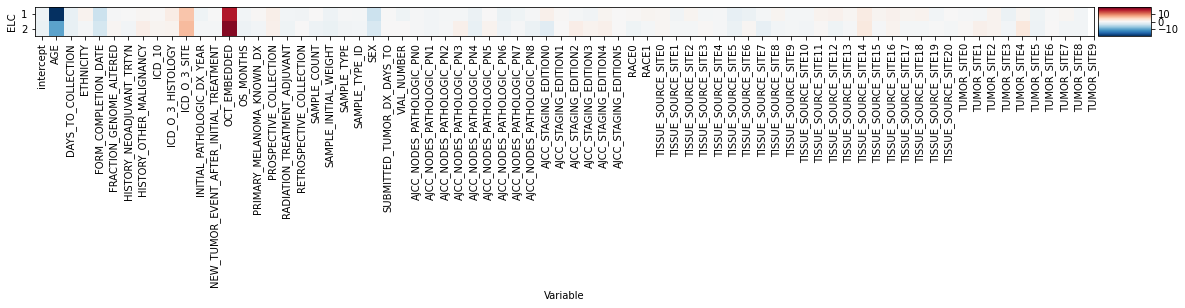

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_mosaic(MODELS, epic_id=range(2), log_trans=False, ax=ax)
# plt.savefig('SKCM_heatmap.pdf')

In [36]:
import string

f, axs = plt.subplots(4, 1, figsize=(10,30), dpi=600)
# f.tight_layout()
plt.subplots_adjust(hspace=0.4)
for i in range(10):
    j = (0, 1, 3, 4, 7, 9, 10, 13, 19, 23)[i]
    ax = plt.subplot(10, 1,i+1)
    plot_ci(MODELS,j,epic_id=range(2),ax=ax,title=True)

# LIME

In [37]:
from lime import lime_tabular
from interpret import show
import time

Elapsed time to compute the importances: 0.004 seconds


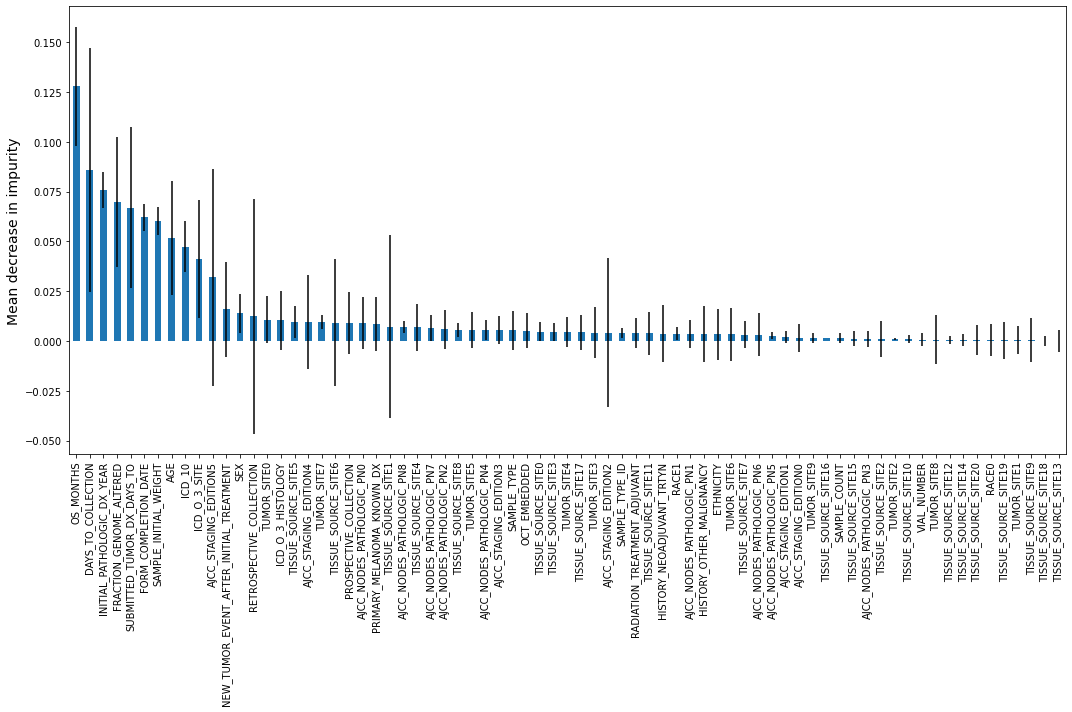

In [38]:
start_time = time.time()
importances = clf_1.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_1.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 10))
forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", fontsize=14)
fig.tight_layout()
fig.savefig(f'./Plots_SKCM/Feature_importance.png', dpi=fig.dpi)

In [39]:
important_10 = np.array(forest_importances[:10].index)

In [40]:
k = 0
ids_imp10 = []
res_models = {}
for f in important_10:
    res_models[f] = {}

def log(x): return np.sign(x)*np.log(np.abs(x)+1)
# def log(x): return x

for i in feature_names:
    if i in important_10:
        print(k, i)
        print('model 1', log(MODELS[0].params[k]), log(MODELS[0].conf_int()[k]))
        print('model 2', log(MODELS[1].params[k]), log(MODELS[1].conf_int()[k]))
        res_models[i]['coef_m1'] = log(MODELS[0].params[k])
        res_models[i]['coef_m2'] = log(MODELS[1].params[k])
        res_models[i]['ci_m1'] = log(MODELS[0].conf_int()[k])
        res_models[i]['ci_m2'] = log(MODELS[1].conf_int()[k])
        ids_imp10.append(k)
    k += 1

0 AGE
model 1 -0.7163943771849168 [-0.96047788 -0.39280748]
model 2 -0.8470224886660749 [-1.10425753 -0.499804  ]
1 DAYS_TO_COLLECTION
model 1 -3.0339805973904403 [-3.1027022  -2.96018553]
model 2 -2.455575617713035 [-2.55298371 -2.347645  ]
3 FORM_COMPLETION_DATE
model 1 0.5605178760753753 [0.27137411 0.78453742]
model 2 -0.2758455503703811 [-0.60520116  0.17926017]
4 FRACTION_GENOME_ALTERED
model 1 -1.6597655850340134 [-1.76208246 -1.54577412]
model 2 -1.4864352321306442 [-1.62670925 -1.32322308]
7 ICD_10
model 1 0.30022703238392756 [-0.24434436  0.68163847]
model 2 0.8570594776290263 [0.49509402 1.12226093]
9 ICD_O_3_SITE
model 1 0.8859297731977729 [0.57142057 1.12483081]
model 2 0.569099529855351 [0.03316654 0.91614205]
10 INITIAL_PATHOLOGIC_DX_YEAR
model 1 1.8616876478473676 [1.73493371 1.97416739]
model 2 1.986675592613977 [1.86299958 2.09672561]
13 OS_MONTHS
model 1 2.8221949411799168 [2.75466891 2.88544821]
model 2 2.9536750393834454 [2.88717164 3.01603018]
19 SAMPLE_INITIAL_WE

In [41]:
def predict_logistic(features, coefficients, intercept=0):
    """
    Predicts probabilities for logistic regression based on features, coefficients, and an optional intercept.

    Parameters:
    features (array-like): A 2D array where each row is a data point and each column is a feature.
    coefficients (array-like): A 1D array of coefficients corresponding to the features.
    intercept (float, optional): The intercept term. Default is 0.

    Returns:
    numpy.ndarray: An array of predicted probabilities.
    """
    # Convert inputs to numpy arrays for matrix operations
    features = np.array(features)
    coefficients = np.array(coefficients)

    # Calculate the linear combination (z)
    linear_combination = np.dot(features, coefficients) + intercept

    # Apply the sigmoid function to get probabilities
    probabilities = 1 / (1 + np.exp(-linear_combination))

    return probabilities

In [42]:
from sklearn.linear_model import Lasso
from lime.lime_tabular import LimeTabularExplainer
from joblib import Parallel, delayed

# Create LIME tabular explainer
explainer = LimeTabularExplainer(
    X_test,
    feature_names=feature_names,
    class_names=df["OS_STATUS"].unique(),
    mode='classification'
)

# Function to generate explanation for a single instance
def explain_instance(index):
#     print(f"\033[1m\nStep: {index}\033[0m")
    instance = X_test[index]

    # Generate explanation using Lasso
    exp = explainer.explain_instance(instance, clf_1.predict_proba, num_features=73, model_regressor=Lasso(alpha=0.001))
    coefs_tuples = sorted(exp.as_map()[1], key=lambda x: x[0])
    coefs = [item[1] for item in coefs_tuples]

    predictions_lime = int(np.round(predict_logistic(instance, coefs, intercept=exp.intercept[1])))
    return exp.as_list(), predictions_lime

# Parallelize using joblib
lime_data = Parallel(n_jobs=1)(delayed(explain_instance)(i) for i in range(len(X_test)))

# Flatten the results if needed
lime_data = [item[0] for item in lime_data]
predictions_lime = [item[1] for item in lime_data]



Step: 0

Step: 1

Step: 2

Step: 3

Step: 4

Step: 5

Step: 6

Step: 7

Step: 8

Step: 9

Step: 10

Step: 11

Step: 12

Step: 13

Step: 14

Step: 15

Step: 16

Step: 17

Step: 18

Step: 19

Step: 20

Step: 21

Step: 22

Step: 23

Step: 24

Step: 25

Step: 26

Step: 27

Step: 28

Step: 29

Step: 30

Step: 31

Step: 32

Step: 33

Step: 34

Step: 35

Step: 36

Step: 37

Step: 38

Step: 39

Step: 40

Step: 41

Step: 42

Step: 43

Step: 44

Step: 45

Step: 46

Step: 47

Step: 48

Step: 49

Step: 50

Step: 51

Step: 52

Step: 53

Step: 54

Step: 55

Step: 56

Step: 57

Step: 58

Step: 59

Step: 60

Step: 61

Step: 62

Step: 63

Step: 64

Step: 65

Step: 66

Step: 67

Step: 68

Step: 69

Step: 70

Step: 71

Step: 72

Step: 73

Step: 74

Step: 75

Step: 76

Step: 77


In [43]:
flattened_list = [item for sublist in lime_data for item in sublist if item]
lime_data = flattened_list

In [44]:
import re

result = {}

def extract_feature(condition):
    match = re.search(r'[A-Za-z_]+[A-Za-z0-9_]*', condition)
    if match:
        return match.group(0)
    return None

# Iterate over the tuples
for condition, value in lime_data:
    feature = extract_feature(condition)
    
    if feature:
        if feature in result:
            result[feature].append(value)
        else:
            result[feature] = [value]

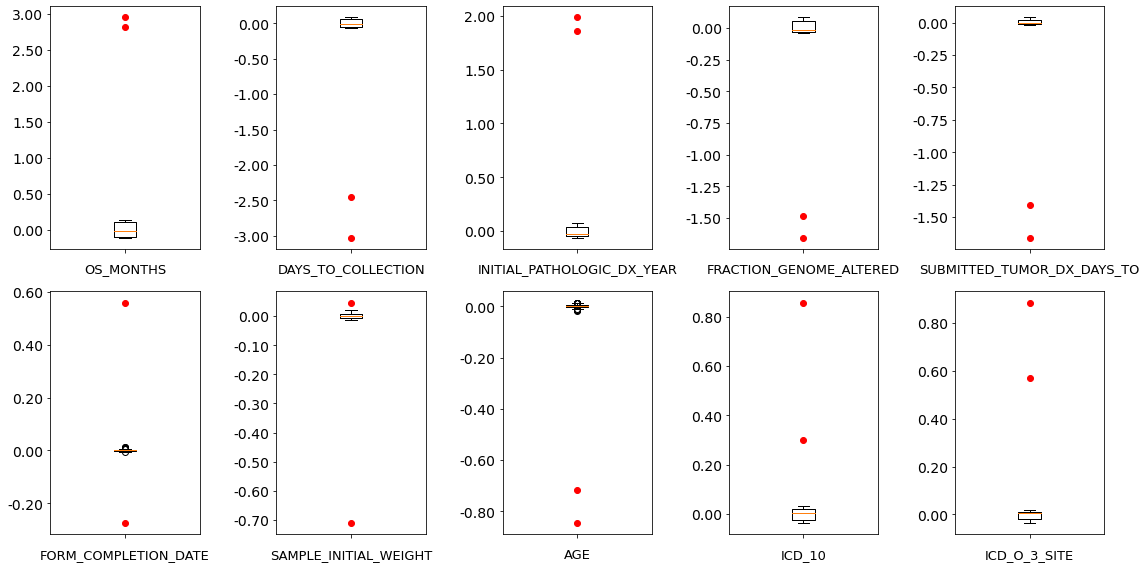

In [45]:
import statistics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

stats_result = {}

n_features = len(important_10)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8))
axs = axs.flatten()

for idx, feature in enumerate(important_10):
    values = result[feature]

    axs[idx].boxplot(log(values))
#     axs[idx].boxplot(res_models_mlm[f'{feature}'])

    point1 = res_models[f'{feature}']['coef_m1']
    point2 = res_models[f'{feature}']['coef_m2']
    
    ci1 = res_models[f'{feature}']['ci_m1']
    ci2 = res_models[f'{feature}']['ci_m2']

    axs[idx].scatter([1, 1], [point1, point2], color='red', zorder=5, label='Coef Points')

    axs[idx].set_xticks([1])
    axs[idx].set_xticklabels([feature], fontsize=13)
    axs[idx].tick_params(axis='x', pad=10)


    yticks = axs[idx].get_yticks()
    yticks = yticks[1:-1]
    axs[idx].set_yticks(yticks)
    axs[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    axs[idx].set_yticklabels([f'{tick:.2f}' for tick in yticks], fontsize=14)
    
plt.tight_layout()
plt.show()
# fig.savefig(f'./Plots_SKCM/ALL-Boxplots-ST-MLM.png', dpi=fig.dpi)

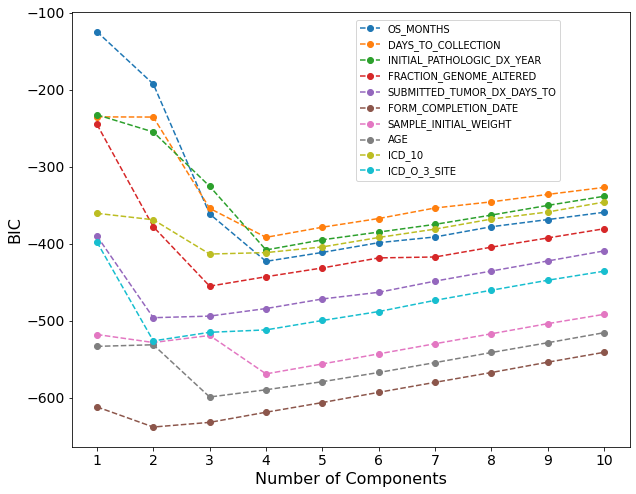

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def compute_bic(X, max_clusters=10):
    n_components = np.arange(1, max_clusters + 1)
    bics = []

    for n in n_components:
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
        gmm.fit(X)
        bics.append(gmm.bic(X))
    
    return n_components, bics

fig = plt.figure(figsize=(10, 8))
for feature in important_10:

    data = np.array(result[f'{feature}'])

    X = data.reshape(-1, 1)

    n_components, bics = compute_bic(X)

    plt.plot(n_components, bics, marker='o', linestyle='--', label=f'{feature}')
    plt.legend(bbox_to_anchor=(0.5, 0.6))
    plt.xlabel('Number of Components', fontsize=16)
    plt.ylabel('BIC', fontsize=16)
    plt.xticks(n_components, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    
plt.show()
# fig.savefig(f'./Plots_SKCM/ALL-BIC-sep-new.png', dpi=fig.dpi)

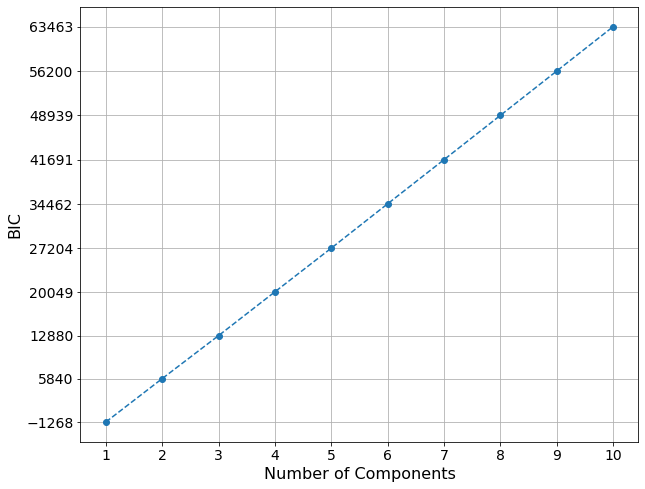

In [47]:
coefs_data = []

for feature in important_10:

    coefs_data.append(np.array(result[f'{feature}']))

n_components, bics = compute_bic(np.array(coefs_data))

fig = plt.figure(figsize=(10, 8))
plt.plot(n_components, bics, marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=16)
plt.ylabel('BIC', fontsize=16)
plt.xticks(n_components, fontsize=14)
plt.yticks(bics, fontsize=14)
plt.grid()
plt.show()
# fig.savefig(f'./Plots_SKCM/BIC-All-new.png', dpi=fig.dpi)
